In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# –ß—Ç–µ–Ω–∏–µ –∏–∑ XML

In [3]:
from xml.dom import minidom

#‚Ä≠ ‚Ä¨–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ñ–∞–π–ª–∞ xml –ø–æ –∏–º–µ–Ω–∏
mydoc = minidom.parse("updated.xml")

items = mydoc.getElementsByTagName("Article")

#‚Ä≠ ‚Ä¨–æ–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ª–µ–º–µ–Ω—Ç–æ–≤
print(len(items))

836


In [4]:
from lxml import etree
def parseXML(xmlFile):
    with open(xmlFile) as fobj:
        xml = fobj.read()
    
    root = etree.fromstring(xml)
 
    article_dict = {}
    articles = []
    for article in root.getchildren():
        for elem in article.getchildren():
            if not elem.text:
                text = "None"
            else:
                text = elem.text
            article_dict[elem.tag] = text
        
        if article.tag == "Article":
            articles.append(article_dict)
            article_dict = {}
    
    return articles

In [5]:
articles = parseXML("updated.xml")
articles = articles[2:]

# –§–æ—Ä–º–∏—Ä—É–µ–º DataFrame

In [6]:
dataframe = pd.DataFrame.from_dict(articles)

In [7]:
dataframe = dataframe[["genre", "text"]]

In [8]:
dataframe = dataframe.dropna()

In [9]:
for i in np.unique(dataframe.genre):
    print(len(dataframe[dataframe.genre == i]))

99
74
403
72
139


# –í—ã—Ä–∞–≤–Ω–∏–≤–∞–µ–º –∫–ª–∞—Å—Å—ã

In [10]:
dataframe_auto = dataframe[dataframe.genre == "AUTO"][:72]
dataframe_winter = dataframe[dataframe.genre == "WINTER"][:72]
dataframe_world = dataframe[dataframe.genre == "WORLD"][:72]
dataframe_town = dataframe[dataframe.genre == "TOWN"][:72]
dataframe_accidents = dataframe[dataframe.genre == "ACCIDENTS"][:72]

In [11]:
frames = [dataframe_auto, dataframe_winter, dataframe_world, dataframe_town, dataframe_accidents]
df = pd.concat(frames)

In [12]:
for i in np.unique(df.genre):
    print(len(df[df.genre == i]))

72
72
72
72
72


In [13]:
df

genre                                               text
0         AUTO  –ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ...
1         AUTO  –ù–µ–¥–æ—Ä–æ–≥–æ–π 5-–º–µ—Ç—Ä–æ–≤—ã–π –º–∏–Ω–∏–≤—ç–Ω –≤–µ–∑—ë—Ç –∫—É—á—É –≤–µ—â–µ–π ...
2         AUTO  –†–µ–∞–≥–∏—Ä—É—è –Ω–∞ —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏—é Mazda 6, –∫–æ—Ç–æ—Ä—É—é —è –≤—ã–ª–æ...
3         AUTO  –ü—Ä–∞–≤—ã –±—ã–ª–∏ —Ç–µ, –∫—Ç–æ –Ω–µ –∂–¥–∞–ª –æ—Ç–∫–∞—Ç–∞ —Ü–µ–Ω, –∞ –ø–æ–∫—É–ø...
4         AUTO  –ö–æ—Ä–æ–ª–∏ –ø–∞—Ä–∫–æ–≤–∫–∏. –ó–∞–±—ã—Ç–∞—è –º–∞—à–∏–Ω–∫–∞ –Ω–∞ –¥–µ—Ç—Å–∫–æ–π –ø–ª...
5         AUTO  –†–∞–∑–±–∏—Ä–∞–µ–º—Å—è, –Ω–∞ —Å–∫–æ–ª—å–∫–æ –ø–æ–¥–æ—Ä–æ–∂–∞–ª–∏ –º–∞—à–∏–Ω—ã –∏ –±–µ...
6         AUTO  –ù–æ–≤—ã–π Duster —É–∂–µ –≤—ã–ø—É—Å–∫–∞–µ—Ç—Å—è –≤ –ï–≤—Ä–æ–ø–µ –ø–æ–¥ –º–∞—Ä–∫...
7         AUTO  –ï—Å—Ç—å –Ω–æ–≤–æ—Å—Ç–∏ —Ö–æ—Ä–æ—à–∏–µ –∏ –Ω–æ–≤–æ—Å—Ç–∏ –ø–ª–æ—Ö–∏–µ: –≤ —ç—Ç–æ–º ...
8         AUTO  –ù–æ–≤–∞—è –ø–æ–¥–±–æ—Ä–∫–∞ –ø—Ä–æ –ª—é–¥–µ–π, –∫–æ—Ç–æ—Ä—ã–º –≤—Å–µ —Ä–∞–≤–Ω–æ –ù–æ...
9         AUTO  Tesla Model 3 —Å–∏–º–≤–æ–ª–∏—á–Ω–∞: –æ—Ç—á–∞—è–Ω–Ω–∞—è –ø–æ–ø—ã—Ç–∫–∞ —Å–¥...
10        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
11        AUTO  –î–ª—è —Ä–æ—Å—Å–∏–π—Å–∫–∏—Ö –∞–≤—Ç–æ–º–æ–±–∏–ª–∏—Å—Ç–æ–≤ –≤–æ–∑–≤—Ä–∞—â–∞—é—Ç—Å—è –ø–æ–ª...
12        AUTO  –ù–∞ –Ω–æ—Å—É –ù–æ–≤—ã–π –≥–æ–¥, –ø–æ—Ä–∞ –≤–∫–ª—é—á–∞—Ç—å—Å—è –≤ –ø—Ä–µ–¥–ø—Ä–∞–∑–¥...
13        AUTO  –ü—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–µ –≥–æ–Ω—â–∏–∫–∏ ‚Äî –æ —Ç–æ–º, –∫–∞–∫ –Ω–æ–≤–∏—á–∫—É ...
14        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
15        AUTO  –†–∞–∑—ä–µ–∑–∂–∞—Ç—å—Å—è –ø—Ä–∏ –º–µ–ª–∫–∏—Ö –î–¢–ü –∑–∞–ø—Ä–µ—Ç–∏–ª–∏, –∑–∞—Ç–æ –∏–Ω...
16        AUTO  –° –Ω–∞—Å—Ç—É–ø–ª–µ–Ω–∏–µ–º —Ö–æ–ª–æ–¥–æ–≤ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è –ø—Ä–∏–≤—ã—á–Ω–∞—è –ª–æ...
17        AUTO  –ù–æ–≤–∞—è –ø–æ–¥–±–æ—Ä–∫–∞ –ø—Ä–æ –ª—é–¥–µ–π, –∫–æ—Ç–æ—Ä—ã–º –≤—Å–µ —Ä–∞–≤–Ω–æ –ù–æ...
18        AUTO  –ù–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ ¬´–¥–ª—è –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏–π¬ª –º—ã –æ—Ç–ø—Ä–∞–≤–∏–ª–∏—Å—å...
19        AUTO  –í —ç—Ç–æ–º –≥—Ä—É–∑–æ–≤–∏–∫–µ –ø–æ—Ä–∞–∂–∞–µ—Ç –≤—Å—ë ‚Äî –æ—Ç —Ä–∞–∑–º–µ—Ä–æ–≤ –¥–æ...
20        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
21        AUTO  –†–∞–∑–±–∏—Ä–∞–µ–º—Å—è, –∫–∞–∫ –æ—Å–µ–Ω–Ω—è—è ¬´–∏–Ω—Ñ–ª—è—Ü–∏—è¬ª –±—å–µ—Ç —Ä–µ–∫–æ—Ä...
22        AUTO  –ü—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ –∫—Ä—É–ø–Ω—ã–µ –Ω–µ—Ñ—Ç—è–Ω—ã–µ –∫–æ–º–ø–∞–Ω–∏–∏ –¥–æ—Å—Ç...
23        AUTO  –í –ø–µ—Ä–≤—ã–π –¥–µ–Ω—å –Ω–æ—è–±—Ä—è –Ω–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –ì–ò–ë–î–î –ø—Ä–æ–≤–µ...
24        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
25        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
26        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
27        AUTO  –ñ–∏—Ç–µ–ª—å–Ω–∏—Ü–∞ –ù–∏–∂–Ω–µ–≥–æ –ù–æ–≤–≥–æ—Ä–æ–¥–∞ –ï–∫–∞—Ç–µ—Ä–∏–Ω–∞ –ú–∏—Ä–æ–Ω–æ–≤...
28        AUTO  –ü–æ—Ä—Ç–∞–ª NN.ru –ø—Ä–æ–¥–æ–ª–∂–∞–µ—Ç –ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏–∏...
29        AUTO  –ú–Ω–µ –æ—á–µ–Ω—å –Ω–µ —Ö–æ—á–µ—Ç—Å—è, —á—Ç–æ–±—ã –Ω–∞—Å—Ç—É–ø–∏–ª–æ –±—É–¥—É—â–µ–µ,...
..         ...                                                ...
770  ACCIDENTS  –û—á–µ–≤–∏–¥—Ü—ã –≥–æ–≤–æ—Ä—è—Ç, —á—Ç–æ –µ—â–µ –æ–¥–Ω–æ –≤–æ–∑–≥–æ—Ä–∞–Ω–∏–µ –±—ã–ª–æ...
771  ACCIDENTS  –°—Ä–∞–∑—É –∏–∑ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —à–∫–æ–ª –ù–∏–∂–Ω–µ–≥–æ –ù–æ–≤–≥–æ—Ä–æ–¥–∞ —Å–µ–≥...
772  ACCIDENTS  –¢—Ä–æ–µ –∏–∑ —Ç—Ä–∏–Ω–∞–¥—Ü–∞—Ç–∏ —É—Å—ã–Ω–æ–≤–ª–µ–Ω–Ω—ã—Ö –¥–µ—Ç–µ–π –æ–±–≤–∏–Ω—è—é—Ç...
773  ACCIDENTS  –í–æ–ª–Ω–∞ –∞–Ω–æ–Ω–∏–º–Ω—ã—Ö –∑–≤–æ–Ω–∫–æ–≤ –æ –∑–∞–ª–æ–∂–µ–Ω–Ω—ã—Ö –≤–∑—Ä—ã–≤–Ω—ã—Ö ...
774  ACCIDENTS  –û–±–µ—Å–ø–æ–∫–æ–µ–Ω–Ω—ã–µ —Ä–æ–¥–∏—Ç–µ–ª–∏ –∏ —à–∫–æ–ª—å–Ω–∏–∫–∏ —Å–æ–æ–±—â–∞—é—Ç –æ ...
775  ACCIDENTS  –í–æ –≤—Ç–æ—Ä–Ω–∏–∫, 12 —Å–µ–Ω—Ç—è–±—Ä—è, –≤–µ—á–µ—Ä–æ–º –≤ –ù–∏–∂–Ω–µ–º –ù–æ–≤–≥...
776  ACCIDENTS  –ù–∞ —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏–∏ –û–ê–û ¬´–ì–ê–ó¬ª –ø—Ä–æ–∏–∑–æ—à–ª–æ –º–∞—Å—Å–æ–≤–æ–µ —É–±–∏...
777  ACCIDENTS  –ù–∏–∂–µ–

In [13]:
corpus, texts = [], []

for message in log_progress(df.text.dropna().as_matrix()):
    sp = message.split()
    corpus += sp
    texts += sp
#     break

print(len(corpus), len(texts))

C:\Users\B7E3~1\AppData\Local\conda\conda\envs\labsras\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


268897 268897


In [14]:
corpus[268896]

'–î–¢–ü.'

In [15]:
#–£–±–∏—Ä–∞–µ–º –ø—Ä–æ–±–µ–ª—ã
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

268897


In [16]:
#–£–±–µ—Ä–µ–º –¥—Ä—É–≥–∏–µ –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
EXCLUDE_SYMBOLS_STR = u''.join(['‚Ññ', '¬´', '—í', '¬∞', '¬±', '‚Äö', '—õ', '‚Ä∞', '‚Ä¶', '¬ª', '—ì', '¬µ', '¬∑', '“ë', '—ö', '—ó', '—ü', '—î', '‚Äπ',
                                '‚Ä°', '‚Ä†', '¬∂', '—ú', '‚Ç¨', '‚Äú', '—û', '¬ß', '‚Äû', '‚Äù', '\ufeff', '‚Äô', '—ô', '‚Ä∫', '‚Ä¢', '‚Äî', '‚Äò', 
                                '\x7f', '\xad', '¬§', '\xa0'])
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [18]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [19]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [20]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

268897


In [21]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [22]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

268897


In [23]:
corpus[268896]

'–î–¢–ü'

In [24]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

255478
255478


In [25]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

255478


In [26]:
print(texts[0])
print(corpus[0])

–ú—ã
–º—ã


In [27]:
morph = pymorphy2.MorphAnalyzer()

In [28]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

154991 255478


In [29]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

255478
154991


In [30]:
stemmer = RussianStemmer()

In [31]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

154991


In [32]:
print(len(corpus_tokens))
corpus_tokens[:10]

154991


[['—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å'],
 ['–∫—É–ø–∏—Ç—å'],
 ['–¥–µ—à—ë–≤—É—é'],
 ['—Å—Ç—Ä–∞—Ö–æ–≤–∫—É'],
 ['–Ω–æ–≤—ã–º'],
 ['—Ç–∞—Ä–∏—Ñ–∞–º'],
 ['—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å'],
 ['–∫—É–ø–∏—Ç—å'],
 ['–¥–µ—à—ë–≤—É—é'],
 ['—Å—Ç—Ä–∞—Ö–æ–≤–∫—É']]

In [33]:
print(len(corpus_tokens_stem))
corpus_tokens_stem[:10]

154991


[['—Ä–∞–∑–æ–±—Ä–∞'],
 ['–∫—É–ø'],
 ['–¥–µ—à–µ–≤'],
 ['—Å—Ç—Ä–∞—Ö–æ–≤–∫'],
 ['–Ω–æ–≤'],
 ['—Ç–∞—Ä–∏—Ñ'],
 ['—Ä–∞–∑–æ–±—Ä–∞'],
 ['–∫—É–ø'],
 ['–¥–µ—à–µ–≤'],
 ['—Å—Ç—Ä–∞—Ö–æ–≤–∫']]

In [34]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

154991 154991


In [35]:
diffs = np.asarray([len(tokens[0]) for tokens in corpus_tokens_stem])
print(len(diffs))

154991


In [36]:
diffs

array([7, 3, 5, ..., 5, 6, 3])

(0, 30)

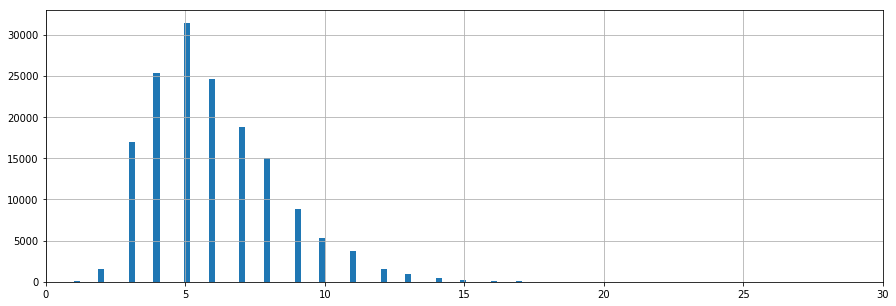

In [37]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [38]:
corpus_tokens_stem[diffs == 2][:10]

array([list(['—è–º']), list(['–æ—Å']), list(['–æ–±']), list(['—É–º']),
       list(['—Ç–æ']), list(['–∏–Ω']), list(['—Ç–æ']), list(['–º–æ']),
       list(['–∏–º']), list(['–º–∞'])], dtype=object)

In [39]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.10839984257150415

In [40]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

16801 16801


In [41]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

16801 16801


In [42]:
texts

array(['—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å,', '–∫—É–ø–∏—Ç—å', '–¥–µ—à—ë–≤—É—é', ..., '–º—á–∞–ª—Å—è', '–±–∞–ª–ª–æ–Ω',
       '–ø–∞—Å—Å–∞–∂–∏—Ä–∫–∞'], dtype='<U31')

In [43]:
diffs = np.asarray([len(tokens[0]) for tokens in corpus_tokens_stem])
print(len(diffs))

16801


In [44]:
diffs

array([7, 3, 5, ..., 4, 6, 9])

(0, 10)

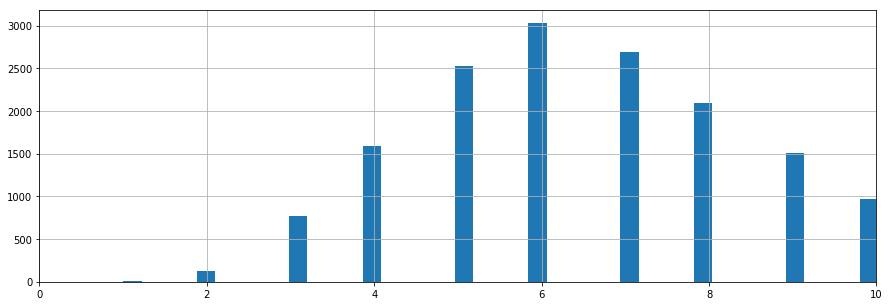

In [45]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [46]:
corpus_tokens_stem[diffs == 7]

array([list(['—Ä–∞–∑–æ–±—Ä–∞']), list(['–∫–æ—Ä–∏–¥–æ—Ä']), list(['—Å—Ç—Ä–∞—Ö–æ–≤']), ...,
       list(['–±—Ä–∞—Å–ª–µ—Ç']), list(['–º–∏–ª–æ–≤—Å–∫']), list(['–ª–µ—Å–æ–≤–æ–∑'])],
      dtype=object)

In [47]:
corp4learning = corpus_tokens_stem[diffs > 2]
texts4learning = texts[diffs > 2]

In [48]:
corp4learning

array([list(['—Ä–∞–∑–æ–±—Ä–∞']), list(['–∫—É–ø']), list(['–¥–µ—à–µ–≤']), ...,
       list(['–º—á–∞–ª']), list(['–±–∞–ª–ª–æ–Ω']), list(['–ø–∞—Å—Å–∞–∂–∏—Ä–∫'])],
      dtype=object)

In [49]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [50]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

16629


In [14]:
import os
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neighbors import NearestNeighbors
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
data_train = []
for j in df["text"]:
    data_train.append(j)

In [20]:
data_train[0]

'–ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –° –Ω–∞—á–∞–ª–∞ –≥–æ–¥–∞ –∫–æ—Ä–∏–¥–æ—Ä —Ç–∞—Ä–∏—Ñ–æ–≤ –û–°–ê–ì–û —Ä–∞—Å—à–∏—Ä–∏–ª–∏ –Ω–∞ 20% –∏ –≤–≤–µ—Ä—Ö, –∏ –≤–Ω–∏–∑. –≠—Ç–æ –¥–∞–ª–æ —Å—Ç—Ä–∞—Ö–æ–≤—ã–º –∫–æ–º–ø–∞–Ω–∏—è–º –≤—ã–±–æ—Ä: –æ—Å—Ç–∞–≤–∏—Ç—å —Ü–µ–Ω—ã, –ø–æ–≤—ã—Å–∏—Ç—å –∏–ª–∏ —Å–Ω–∏–∑–∏—Ç—å. –ú—ã –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏ —Å—Ç–æ–∏–º–æ—Å—Ç—å –ø–æ–ª–∏—Å–æ–≤ –≤ —Ä–µ–≥–∏–æ–Ω–∞—Ö –†–æ—Å—Å–∏–∏, –∏ –æ–∫–∞–∑–∞–ª–æ—Å—å, —á—Ç–æ –Ω–∞–π—Ç–∏ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ–¥–µ—à–µ–≤–ª–µ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –º–æ–∂–Ω–æ ‚Äî —Ç–∞—Ä–∏—Ñ—ã —Å—Ç—Ä–∞—Ö–æ–≤—ã—Ö –∫–æ–º–ø–∞–Ω–∏–π –æ—Ç–ª–∏—á–∞—é—Ç—Å—è —Å–∏–ª—å–Ω–µ–µ, —á–µ–º –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É. –ì–∏–±–∫–∏–µ —Ç–∞—Ä–∏—Ñ—ã –û–°–ê–ì–û –¥–æ–ª–∂–Ω—ã –±—ã–ª–∏ ¬´–Ω–∞–∫–∞–∑–∞—Ç—å¬ª –∞–≤–∞—Ä–∏–π–Ω—ã—Ö –≤–æ–¥–∏—Ç–µ–ª–µ–π, –Ω–æ –Ω–∞ –¥–µ–ª–µ –≤—Å—ë –æ–∫–

In [21]:
vectorizer = TfidfVectorizer(stop_words=None, strip_accents='unicode')
tfidf_train = vectorizer.fit_transform(data_train)

print(tfidf_train.shape)

(360, 45931)


<360x45931 sparse matrix of type '<class 'numpy.float64'>'
	with 156417 stored elements in Compressed Sparse Row format>

In [16]:
predictor = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(tfidf_train)

In [62]:
near = NearestNeighbors(n_neighbors=1, algorithm='brute', metric="euclidean").fit(tfidf_train)

In [107]:
near_1 = NearestNeighbors(n_neighbors=1, algorithm='brute', metric="cityblock").fit(tfidf_train)

In [27]:
request = "–ì–¥–µ –≤ –†–æ—Å—Å–∏–∏ —Å —Ç—É—Ä–∏—Å—Ç–æ–≤ –Ω–∞—á–Ω—É—Ç —Å–æ–±–∏—Ä–∞—Ç—å –¥–µ–Ω—å–≥–∏"

In [28]:
tfidf_test = vectorizer.transform([vectorizer.decode(request)])

print(tfidf_test.shape)

(1, 45931)


In [29]:
vectorizer.vocabulary_

{'–º—ã': 20037,
 '—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å': 33676,
 '–º–æ–∂–Ω–æ': 19562,
 '–ª–∏': 17695,
 '–∫—É–ø–∏—Ç—å': 17154,
 '–¥–µ—à–µ–≤—É—é': 9599,
 '—Å—Ç—Ä–∞—Ö–æ–≤–∫—É': 39353,
 '–ø–æ': 27145,
 '–Ω–æ–≤—ã–º': 22284,
 '—Ç–∞—Ä–∏—Ñ–∞–º': 40107,
 '–Ω–∞—á–∞–ª–∞': 21094,
 '–≥–æ–¥–∞': 8062,
 '–∫–æ—Ä–∏–¥–æ—Ä': 16274,
 '—Ç–∞—Ä–∏—Ñ–æ–≤': 40113,
 '–æ—Å–∞–≥–æ': 24267,
 '—Ä–∞—Å—à–∏—Ä–∏–ª–∏': 34299,
 '–Ω–∞': 20101,
 '20': 294,
 '–≤–≤–µ—Ä—Ö': 4761,
 '–≤–Ω–∏–∑': 5716,
 '—ç—Ç–æ': 45645,
 '–¥–∞–ª–æ': 8934,
 '—Å—Ç—Ä–∞—Ö–æ–≤—ã–º': 39366,
 '–∫–æ–º–ø–∞–Ω–∏—è–º': 15859,
 '–≤—ã–±–æ—Ä': 6804,
 '–æ—Å—Ç–∞–≤–∏—Ç—å': 24492,
 '—Ü–µ–Ω—ã': 44153,
 '–ø–æ–≤—ã—Å–∏—Ç—å': 27364,
 '–∏–ª–∏': 13754,
 '—Å–Ω–∏–∑–∏—Ç—å': 37438,
 '–ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏': 31619,
 '—Å—Ç–æ–∏–º–æ—Å—Ç—å': 39202,
 '–ø–æ–ª–∏—Å–æ–≤': 28632,
 '—Ä–µ–≥–∏–æ–Ω–∞—Ö': 34434,
 '—Ä–æ—Å—Å–∏–∏': 35096,
 '–æ–∫–∞–∑–∞–ª–æ—Å—å': 23618,
 '—á—Ç–æ': 44695,
 '–Ω–∞–∏—Ç–∏': 20425,
 '–ø–æ–¥–µ—à–µ–≤–ª–µ': 27674,
 '–¥–µ–∏—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ': 9276,
 '—Ç–∞—Ä–∏—Ñ—ã': 40115,
 '—

In [30]:
print(tfidf_test)

  (0, 41344)	0.477719078038
  (0, 37557)	0.564804426715
  (0, 35096)	0.224974509771
  (0, 21163)	0.503216404834
  (0, 9413)	0.340148048695
  (0, 7748)	0.182316940709


In [31]:
for i in tfidf_test.indices:
    print(str(i) + " " + str(vectorizer.get_feature_names()[i]))

41344 —Ç—É—Ä–∏—Å—Ç–æ–≤
37557 —Å–æ–±–∏—Ä–∞—Ç—å
35096 —Ä–æ—Å—Å–∏–∏
21163 –Ω–∞—á–Ω—É—Ç
9413 –¥–µ–Ω—å–≥–∏
7748 –≥–¥–µ


In [96]:
distances, inds_pred = predictor.kneighbors(tfidf_test, n_neighbors=13)

In [90]:
distances_1, inds_pred_1 = near.kneighbors(tfidf_test, n_neighbors=13)

In [108]:
distances_2, inds_pred_2 = near_1.kneighbors(tfidf_test, n_neighbors=13)

In [109]:
distances = np.squeeze(distances)
inds_pred = np.squeeze(inds_pred)
distances_1 = np.squeeze(distances_2)
inds_pred_1 = np.squeeze(inds_pred_2)

(0, 1)

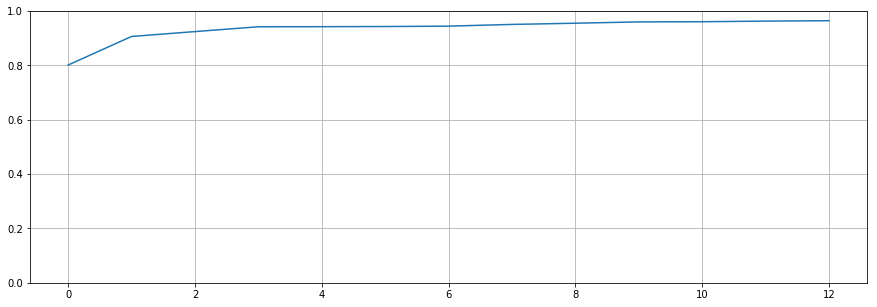

In [110]:
plt.figure(figsize=(15, 5))

plt.plot(distances)
plt.grid(True)
plt.ylim(0, 1)

(6, 12)

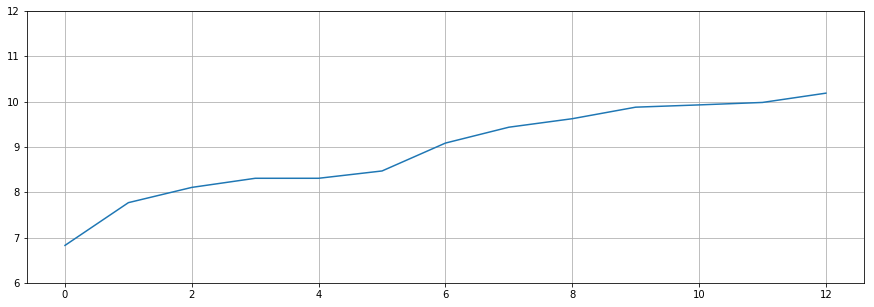

In [122]:
plt.figure(figsize=(15, 5))

plt.plot(distances_1)
plt.grid(True)
plt.ylim(6, 12)

In [112]:
inds_pred

array([157, 148, 146, 337, 194, 133, 153, 188, 158,   6, 332, 193, 136], dtype=int64)

In [113]:
inds_pred_1

array([ 62,  88, 351,  95, 211, 227, 352, 341,  85,  97,  60,  40, 190], dtype=int64)

In [117]:
for i, item in enumerate(inds_pred, start=1):
    print('--------------------------- Top-{} ---------------------------'.format(i))
    print(data_train[item])
    print('---------------------------- end -----------------------------')
    print()

--------------------------- Top-1 ---------------------------
–ì–¥–µ –≤ –†–æ—Å—Å–∏–∏ —Å —Ç—É—Ä–∏—Å—Ç–æ–≤ –Ω–∞—á–Ω—É—Ç —Å–æ–±–∏—Ä–∞—Ç—å –¥–µ–Ω—å–≥–∏ –Ω–∞ –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –∏ –∑–∞—á–µ–º –≤—Å–µ–º –ø—Ä–∏–µ–∑–∂–∏–º –≤ –≥–æ—Ä–æ–¥–∞—Ö, –ø—Ä–∏–Ω–∏–º–∞—é—â–∏—Ö –º—É–Ω–¥–∏–∞–ª—å, –Ω–∞–¥–æ –±—É–¥–µ—Ç –∏–¥—Ç–∏ –≤ –ø–æ–ª–∏—Ü–∏—é ‚Äî —á–∏—Ç–∞–π—Ç–µ –≤ –Ω–∞—à–µ–º –º–∞—Ç–µ—Ä–∏–∞–ª–µ –æ –Ω–æ–≤—ã—Ö –∑–∞–∫–æ–Ω–∞—Ö, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—É–ø—è—Ç –≤ —Å–∏–ª—É –≤ –º–∞–µ 2018 –≥–æ–¥–∞. –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –∑–∞—Ä–ø–ª–∞—Ç–∞ –≤ –†–æ—Å—Å–∏–∏ –≤—ã—Ä–∞—Å—Ç–µ—Ç –¥–æ 11 163 —Ä—É–±–ª–µ–π –ú–∏–Ω–∏–º–∞–ª—å–Ω—É—é –∑–∞—Ä–ø–ª–∞—Ç—É –ø–æ–¥—Ç—è–Ω—É—Ç –∫ –ø—Ä–æ–∂–∏—Ç–æ—á–Ω–æ–º—É –º–∏–Ω–∏–º—É–º—É –° 1 –º–∞—è 2018 –≥–æ–¥–∞ —Ñ–µ–¥–µ—Ä–∞–ª—å–Ω—ã–π –ú–†–û–¢ –≤—ã—Ä–∞—Å—Ç–∞–µ—Ç –Ω–∞ 17% ‚Äî –¥–æ 11 163 —Ä—É–±–ª–µ–π –≤ –º–µ—Å—è—Ü. –°–µ–π—á–∞—Å –ú–†–û–¢ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç 9489 —Ä—É–±–ª–µ–π. –ï–≥–æ –ø—Ä–∏—Ä–∞–≤–Ω—è–ª–∏ –∫ –≤–µ–ª–∏—á–∏–Ω–µ –ø—Ä–æ–∂–∏—Ç–æ—á–Ω–æ–≥–æ –º–∏–Ω–∏–º—É–º–∞ —Ç—Ä—É–¥–æ—Å–ø–æ—Å–æ–±–Ω–æ–≥–æ –Ω–∞—Å–

In [118]:
for i, item in enumerate(inds_pred_1, start=1):
    print('--------------------------- Top-{} ---------------------------'.format(i))
    print(data_train[item])
    print('---------------------------- end -----------------------------')
    print()

--------------------------- Top-1 ---------------------------
–ò—Ö –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è –æ–±—É—Å—Ç—Ä–æ–∏—Ç—å –≤ —ç—Ç–æ–º –≥–æ–¥—É –ò—Ö –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è –æ–±—É—Å—Ç—Ä–æ–∏—Ç—å –≤ —ç—Ç–æ–º –≥–æ–¥—É –í –ù–∏–∂–Ω–µ–º –ù–æ–≤–≥–æ—Ä–æ–¥–µ –≤ —ç—Ç–æ–º –≥–æ–¥—É –≤–ª–∞—Å—Ç–∏ –ø–ª–∞–Ω–∏—Ä—É—é—Ç —Å–¥–µ–ª–∞—Ç—å 56 –ø–ª–∞—Ç–Ω—ã—Ö –ø–∞—Ä–∫–æ–≤–æ–∫. –≠—Ç–æ –∏ –Ω–µ–±–æ–ª—å—à–∏–µ —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏–∏ –≤–æ–∑–ª–µ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö –¥–æ–º–æ–≤, –∏ —Ü–µ–ª—ã–µ —É–ª–∏—Ü—ã. NN.RU —Å–æ—Å—Ç–∞–≤–∏–ª –∫–∞—Ä—Ç—É –±—É–¥—É—â–∏—Ö —Å—Ç–æ—è–Ω–æ–∫. –°–∫–æ—Ä–æ –ø–æ—á—Ç–∏ –≤—Å–µ –ø–∞—Ä–∫–æ–≤–∫–∏ –≤ —Ü–µ–Ω—Ç—Ä–µ –ù–∏–∂–Ω–µ–≥–æ —Å—Ç–∞–Ω—É—Ç –ø–ª–∞—Ç–Ω—ã–º–∏ –ü–ª–∞—Ç–Ω—ã–µ –ø–∞—Ä–∫–æ–≤–∫–∏ –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –ø–æ—è–≤—è—Ç—Å—è –≤ —Ü–µ–Ω—Ç—Ä–µ –≥–æ—Ä–æ–¥–∞, —Ç–∞–∫–∂–µ –ø–∞—Ä–∞ —Å—Ç–æ—è–Ω–æ–∫ —Å—Ç–∞–Ω–µ—Ç –ø–ª–∞—Ç–Ω–æ–π –≤ –ö–∞–Ω–∞–≤–∏–Ω—Å–∫–æ–º —Ä–∞–π–æ–Ω–µ. –ö–∞–∫ —Å–æ–æ–±—â–∏–ª–∏ NN.RU –≤ –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ü–∏–∏ –ù–∏–∂–Ω–µ–≥–æ –ù–æ–≤–≥–æ—Ä–æ–¥–∞, –æ–±—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –ø–ª–∞—Ç–Ω—ã—Ö –ø–∞—Ä–∫–æ–≤–æ–∫ –ø–ª–∞–Ω–∏—Ä—

# Build Models

In [86]:
dataframe_auto = dataframe[dataframe.genre == "AUTO"][:60]
dataframe_winter = dataframe[dataframe.genre == "WINTER"][:60]
dataframe_world = dataframe[dataframe.genre == "WORLD"][:60]
dataframe_town = dataframe[dataframe.genre == "TOWN"][:60]
dataframe_accidents = dataframe[dataframe.genre == "ACCIDENTS"][:60]
# –ò–∑–º–µ–Ω–∏—Ç—å 60 –Ω–∞ 61:72

In [87]:
dataframe_auto_2 = dataframe[dataframe.genre == "AUTO"][61:72]
dataframe_winter_2 = dataframe[dataframe.genre == "WINTER"][61:72]
dataframe_world_2 = dataframe[dataframe.genre == "WORLD"][61:72]
dataframe_town_2 = dataframe[dataframe.genre == "TOWN"][61:72]
dataframe_accidents_2 = dataframe[dataframe.genre == "ACCIDENTS"][61:72]

In [88]:
frames = [dataframe_auto, dataframe_winter, dataframe_world, dataframe_town, dataframe_accidents]
df_train_m = pd.concat(frames)

In [89]:
frames = [dataframe_auto_2, dataframe_winter_2, dataframe_world_2, dataframe_town_2, dataframe_accidents_2]
df_test_m = pd.concat(frames)

In [90]:
len(df_train_m)

300

In [91]:
len(df_test_m)

55

In [92]:
df_test_m[:5]

genre                                               text
65  AUTO  –ù–æ–≤–∞—è –ø–æ–¥–±–æ—Ä–∫–∞ –ø—Ä–æ –ª—é–¥–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –ø–∞—Ä–∫—É—é—Ç—Å—è –∫–∞...
66  AUTO  –ò—Ö –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è –æ–±—É—Å—Ç—Ä–æ–∏—Ç—å –≤ —ç—Ç–æ–º –≥–æ–¥—É –ò—Ö –ø–ª–∞–Ω–∏...
67  AUTO  –ö–æ—Ä–æ–ª–∏ –ø–∞—Ä–∫–æ–≤–∫–∏: ¬´–ö—Ä—É–∑–∞–∫ –≥–æ–ª–æ–≤–Ω–æ–≥–æ –º–æ–∑–≥–∞¬ª –ù–æ–≤–∞...
68  AUTO  –í–æ—Ç –∏ –ø—Ä–æ—à–µ–ª 2017 –≥–æ–¥. –í—Ä–æ–¥–µ –±—ã –≤—Å–µ–≥–æ 12 –º–µ—Å—è—Ü...
69  AUTO  –ê–≤—Ç–æ—Ö–∞–º—ã –≤ –≥–æ—Å—Ç—è—Ö —É NN.RU –ê–≤—Ç–æ—Ö–∞–º—ã –≤ –≥–æ—Å—Ç—è—Ö —É ...

In [105]:
data_F = []
for item in df["text"]:
    data_F.append(item)

In [111]:
len(y_train)

300

In [173]:
data_F[:2]

['–ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –° –Ω–∞—á–∞–ª–∞ –≥–æ–¥–∞ –∫–æ—Ä–∏–¥–æ—Ä —Ç–∞—Ä–∏—Ñ–æ–≤ –û–°–ê–ì–û —Ä–∞—Å—à–∏—Ä–∏–ª–∏ –Ω–∞ 20% –∏ –≤–≤–µ—Ä—Ö, –∏ –≤–Ω–∏–∑. –≠—Ç–æ –¥–∞–ª–æ —Å—Ç—Ä–∞—Ö–æ–≤—ã–º –∫–æ–º–ø–∞–Ω–∏—è–º –≤—ã–±–æ—Ä: –æ—Å—Ç–∞–≤–∏—Ç—å —Ü–µ–Ω—ã, –ø–æ–≤—ã—Å–∏—Ç—å –∏–ª–∏ —Å–Ω–∏–∑–∏—Ç—å. –ú—ã –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏ —Å—Ç–æ–∏–º–æ—Å—Ç—å –ø–æ–ª–∏—Å–æ–≤ –≤ —Ä–µ–≥–∏–æ–Ω–∞—Ö –†–æ—Å—Å–∏–∏, –∏ –æ–∫–∞–∑–∞–ª–æ—Å—å, —á—Ç–æ –Ω–∞–π—Ç–∏ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ–¥–µ—à–µ–≤–ª–µ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –º–æ–∂–Ω–æ ‚Äî —Ç–∞—Ä–∏—Ñ—ã —Å—Ç—Ä–∞—Ö–æ–≤—ã—Ö –∫–æ–º–ø–∞–Ω–∏–π –æ—Ç–ª–∏—á–∞—é—Ç—Å—è —Å–∏–ª—å–Ω–µ–µ, —á–µ–º –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É. –ì–∏–±–∫–∏–µ —Ç–∞—Ä–∏—Ñ—ã –û–°–ê–ì–û –¥–æ–ª–∂–Ω—ã –±—ã–ª–∏ ¬´–Ω–∞–∫–∞–∑–∞—Ç—å¬ª –∞–≤–∞—Ä–∏–π–Ω—ã—Ö –≤–æ–¥–∏—Ç–µ–ª–µ–π, –Ω–æ –Ω–∞ –¥–µ–ª–µ –≤—Å—ë –æ–∫

In [108]:
data_full_ = vectorizer.fit_transform(data_F)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_full_, df["genre"])

In [164]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=30, window=2, min_count=1, workers=4)

In [168]:
model.docvecs[0]

array([ 0.75435251, -0.84884143,  1.02085602, -1.2646836 ,  0.6404984 ,
       -0.98779517, -1.98133409, -2.44583535,  1.66087008, -0.6543957 ,
       -0.90666759, -1.37917614,  1.07633352,  0.44287977,  0.02242515,
        1.08529127,  1.68683302,  0.25867757,  0.15885299,  0.47093877,
        0.36399394, -0.33786944, -1.35673201,  0.44339177, -2.58695459,
        0.85597819,  0.30063882,  0.25870949, -0.67346972,  0.08685511], dtype=float32)

In [114]:
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(270, 45931) (90, 45931)
270 90


In [118]:
import os
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [202]:
len(y_test[y_test == "WINTER"])

20

In [199]:
index_of_texts = y_test[(y_test == "WINTER") & (y_pred_lr == "WORLD")]
llll = list(index_of_texts.index)

In [201]:
for i in llll:
    print(data_F[i])
    print("-------------------------------------------------")

–í –≤–æ—Å–∫—Ä–µ—Å–µ–Ω—å–µ, 22 —Ñ–µ–≤—Ä–∞–ª—è, –Ω–∏–∂–µ–≥–æ—Ä–æ–¥—Ü—ã —Å–º–æ–≥—É—Ç –≤–µ—Å–µ–ª–æ –∏ –≤–∫—É—Å–Ω–æ –ø–æ–ø—Ä–æ—â–∞—Ç—å—Å—è —Å –∑–∏–º–æ–π. –û–ø—É–±–ª–∏–∫–æ–≤–∞–Ω–∞ –ø—Ä–æ–≥—Ä–∞–º–º–∞ –ø—Ä–∞–∑–¥–Ω–æ–≤–∞–Ω–∏—è –ú–∞—Å–ª–µ–Ω–∏—Ü—ã –≤ –ù–∏–∂–Ω–µ–º –ù–æ–≤–≥–æ—Ä–æ–¥–µ. –° 15 –ø–æ 22 —Ñ–µ–≤—Ä–∞–ª—è –Ω–∞ –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–æ–π —è—Ä–º–∞—Ä–∫–µ –ø—Ä–æ—Ö–æ–¥–∏—Ç –≤—ã—Å—Ç–∞–≤–∫–∞-—è—Ä–º–∞—Ä–∫–∞ ¬´–®–∏—Ä–æ–∫–∞—è –º–∞—Å–ª–µ–Ω–∏—Ü–∞¬ª. –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Å–º–æ–≥—É—Ç –∫—É–ø–∏—Ç—å –∏–∑–¥–µ–ª–∏—è —Ä—É—á–Ω–æ–π —Ä–∞–±–æ—Ç—ã, –ø–æ—É—á–∞—Å—Ç–≤–æ–≤–∞—Ç—å –≤ –º–∞—Å—Ç–µ—Ä-–∫–ª–∞—Å—Å–∞—Ö, —É–≥–æ—Å—Ç–∏—Ç—å—Å—è –±–ª–∏–Ω–∞–º–∏, –ø–æ—Å–ª—É—à–∞—Ç—å –º—É–∑—ã–∫—É –∏ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –≤—ã—Å—Ç—É–ø–ª–µ–Ω–∏—è –ª—é–±–∏—Ç–µ–ª—å—Å–∫–∏—Ö —Ç–µ–∞—Ç—Ä–æ–≤. –í –≥—Ä—è–¥—É—â–∏–µ –≤—ã—Ö–æ–¥–Ω—ã–µ –¥–ª—è –≥–æ—Å—Ç–µ–π –∏ –∂–∏—Ç–µ–ª–µ–π –ø–æ–≤–æ–ª–∂—Å–∫–æ–π —Å—Ç–æ–ª–∏—Ü—ã –æ—Ä–≥–∞–Ω–∏–∑—É—é—Ç —Å–µ—Ä–∏—é –ø—Ä–∞–∑–¥–Ω–∏—á–Ω—ã—Ö –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–π, –ø–æ—Å–≤—è—â–µ–Ω–Ω—ã—Ö —è—Ä–∫–æ–º—É –∑–∏–º–Ω–µ–º—É –ø—Ä–∞–∑–¥–Ω–∏–∫—É.

In [189]:
index_of_texts = y_test[y_test == "WINTER" & y_pred_lr == "WORLD"]

for ind in list(y_test.index):
    if y_test[ind] == "WINTER" and y_pred_lr[ind] == "WORLD":
        index_of_text.append(ind)
for i in index_of_texts:
    print(data_F[i])

IndexError: index 129 is out of bounds for axis 0 with size 90

In [178]:
data_F[:2]

['–ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –ú—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å, –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –° –Ω–∞—á–∞–ª–∞ –≥–æ–¥–∞ –∫–æ—Ä–∏–¥–æ—Ä —Ç–∞—Ä–∏—Ñ–æ–≤ –û–°–ê–ì–û —Ä–∞—Å—à–∏—Ä–∏–ª–∏ –Ω–∞ 20% –∏ –≤–≤–µ—Ä—Ö, –∏ –≤–Ω–∏–∑. –≠—Ç–æ –¥–∞–ª–æ —Å—Ç—Ä–∞—Ö–æ–≤—ã–º –∫–æ–º–ø–∞–Ω–∏—è–º –≤—ã–±–æ—Ä: –æ—Å—Ç–∞–≤–∏—Ç—å —Ü–µ–Ω—ã, –ø–æ–≤—ã—Å–∏—Ç—å –∏–ª–∏ —Å–Ω–∏–∑–∏—Ç—å. –ú—ã –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏ —Å—Ç–æ–∏–º–æ—Å—Ç—å –ø–æ–ª–∏—Å–æ–≤ –≤ —Ä–µ–≥–∏–æ–Ω–∞—Ö –†–æ—Å—Å–∏–∏, –∏ –æ–∫–∞–∑–∞–ª–æ—Å—å, —á—Ç–æ –Ω–∞–π—Ç–∏ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ–¥–µ—à–µ–≤–ª–µ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –º–æ–∂–Ω–æ ‚Äî —Ç–∞—Ä–∏—Ñ—ã —Å—Ç—Ä–∞—Ö–æ–≤—ã—Ö –∫–æ–º–ø–∞–Ω–∏–π –æ—Ç–ª–∏—á–∞—é—Ç—Å—è —Å–∏–ª—å–Ω–µ–µ, —á–µ–º –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É. –ì–∏–±–∫–∏–µ —Ç–∞—Ä–∏—Ñ—ã –û–°–ê–ì–û –¥–æ–ª–∂–Ω—ã –±—ã–ª–∏ ¬´–Ω–∞–∫–∞–∑–∞—Ç—å¬ª –∞–≤–∞—Ä–∏–π–Ω—ã—Ö –≤–æ–¥–∏—Ç–µ–ª–µ–π, –Ω–æ –Ω–∞ –¥–µ–ª–µ –≤—Å—ë –æ–∫

In [120]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [121]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [122]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [123]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [125]:
y_pred_lr = predictor_lr.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr), 2)))

LR accuracy: 0.83%


In [126]:
y_pred_svm = predictor_svm.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm), 2)))

LR accuracy: 0.8%


In [127]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.68%


In [128]:
y_pred_gbt = predictor_gbt.predict(X_test)
print('GBT accuracy: {}%'.format(round(np.mean(y_test == y_pred_gbt), 2)))

GBT accuracy: 0.63%


In [129]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [132]:
initial_categories = ["AUTO", 'WINTER', 'WORLD', 'TOWN', 'ACCIDENTS']

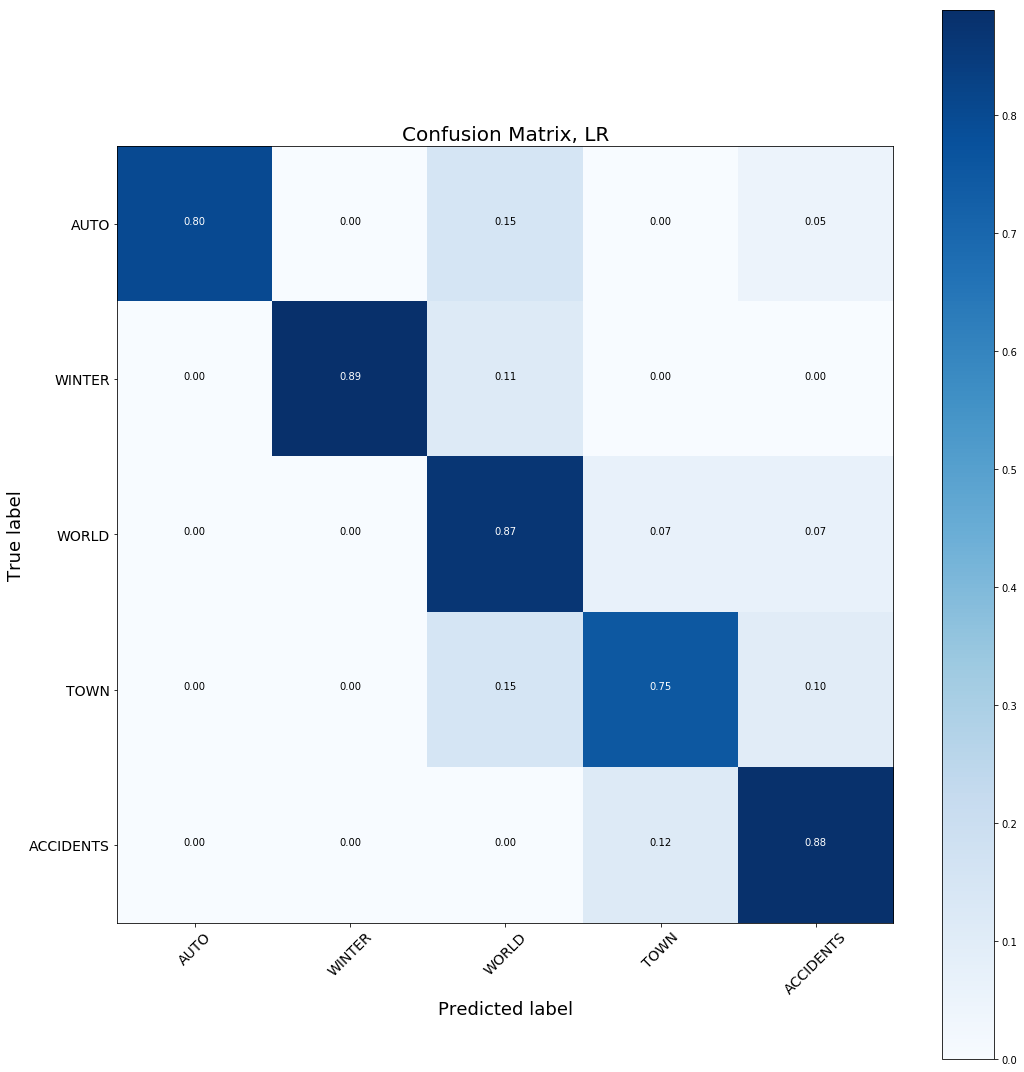

In [133]:
cmt_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cmt_lr, title='Confusion Matrix, LR')

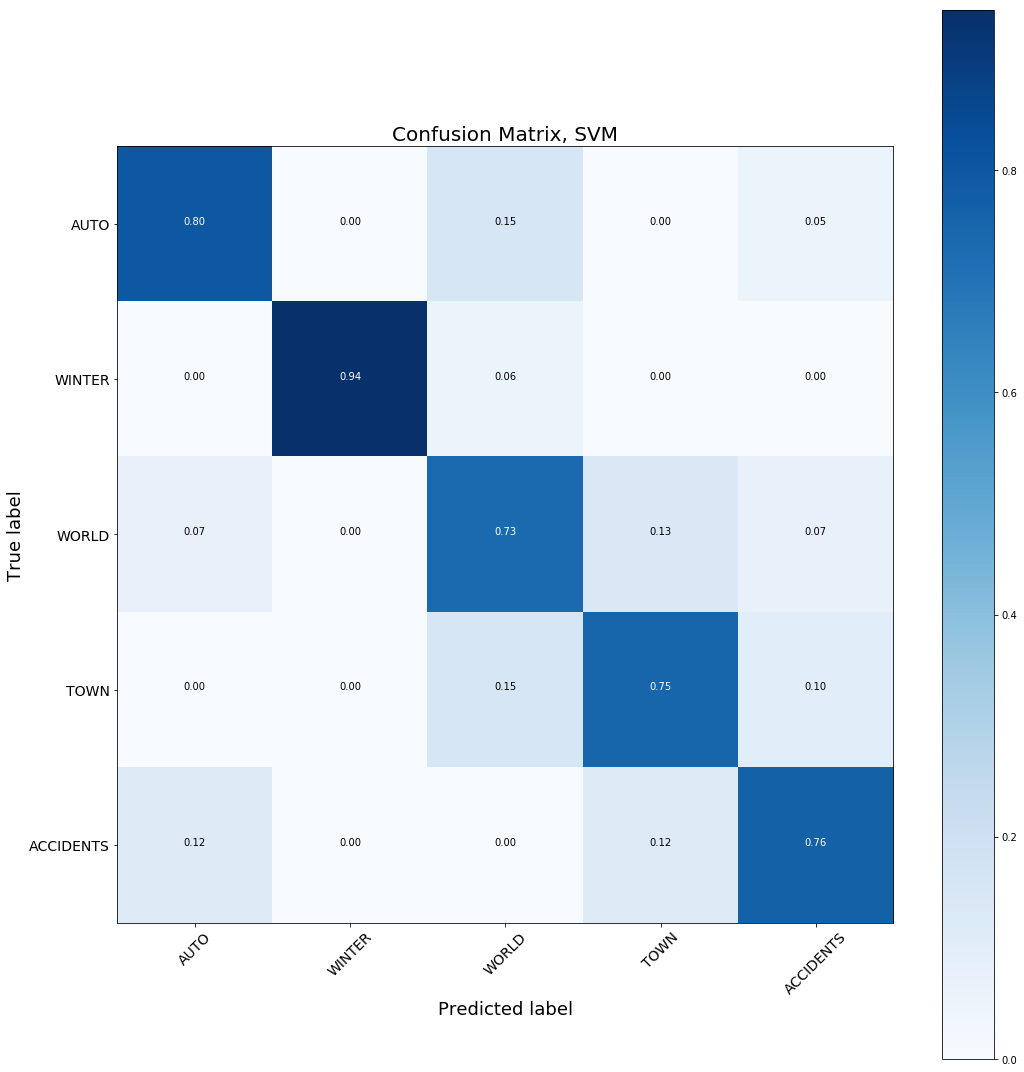

In [134]:
cmt_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cmt_svm, title='Confusion Matrix, SVM')

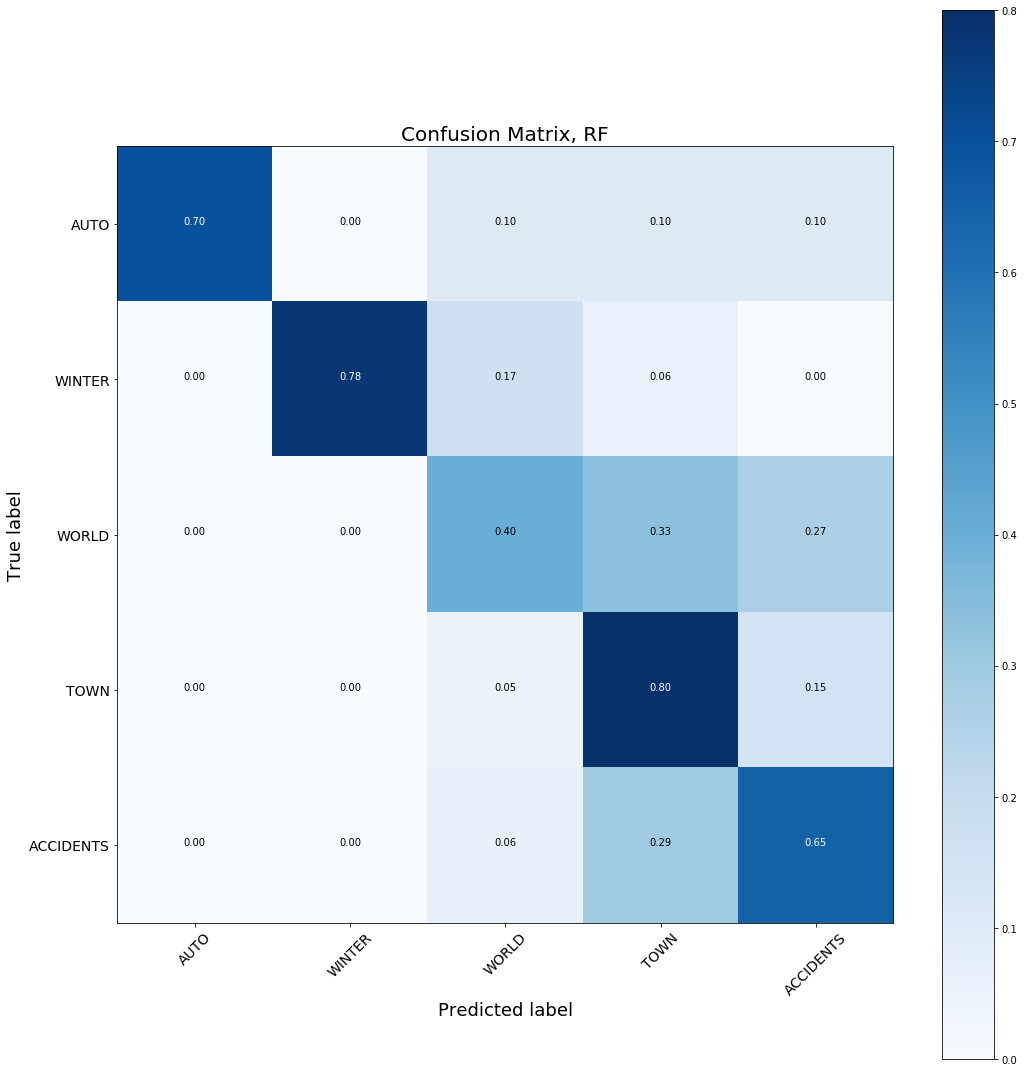

In [135]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

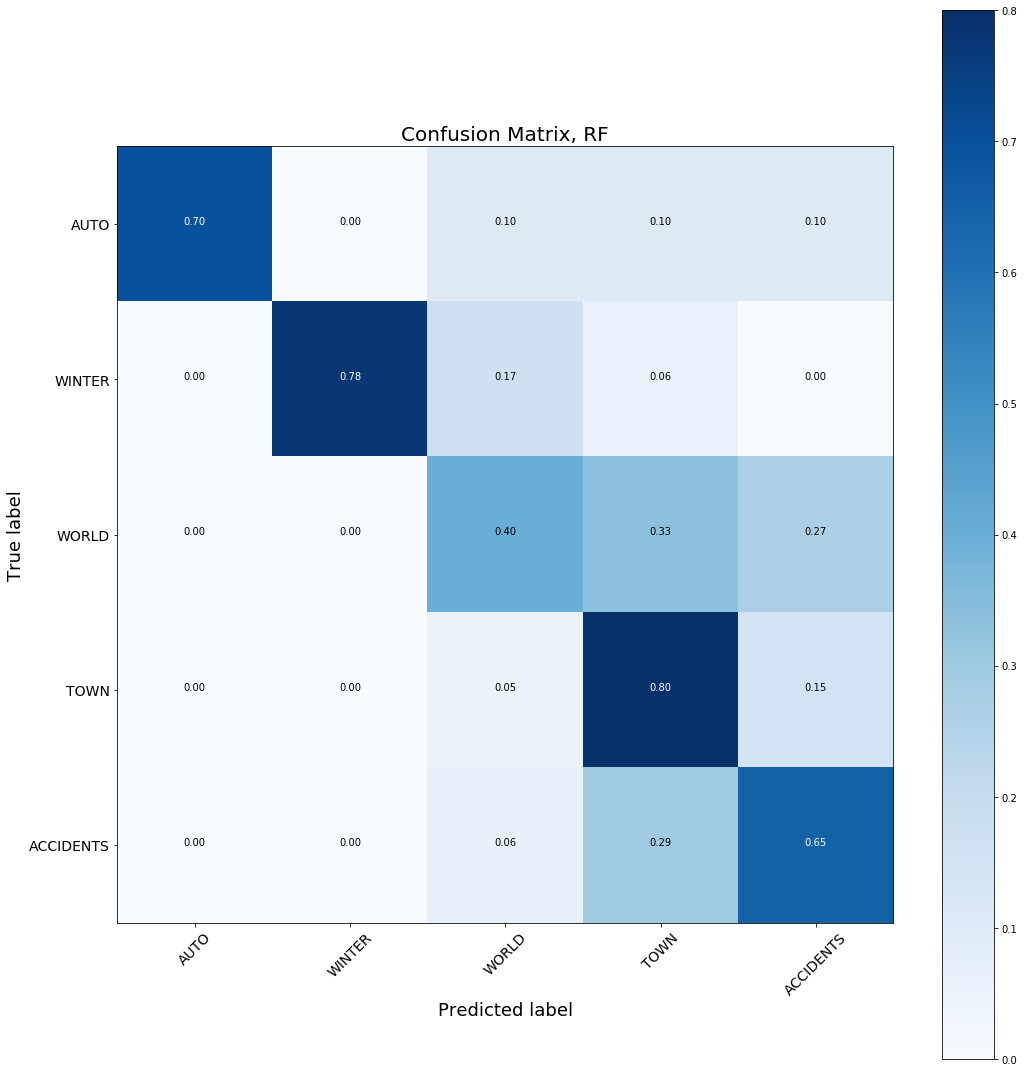

In [136]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

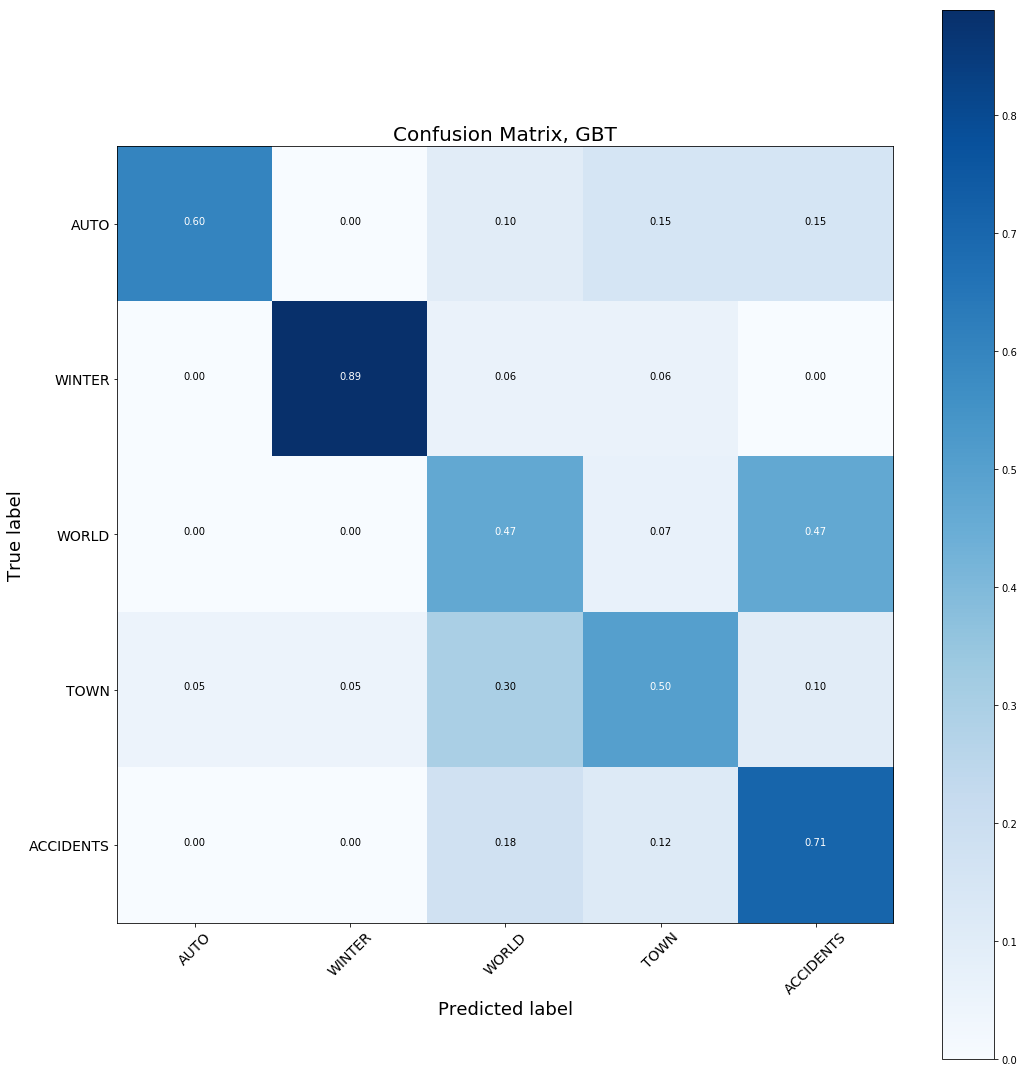

In [137]:
cmt_gbt = confusion_matrix(y_test, y_pred_gbt)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, GBT')

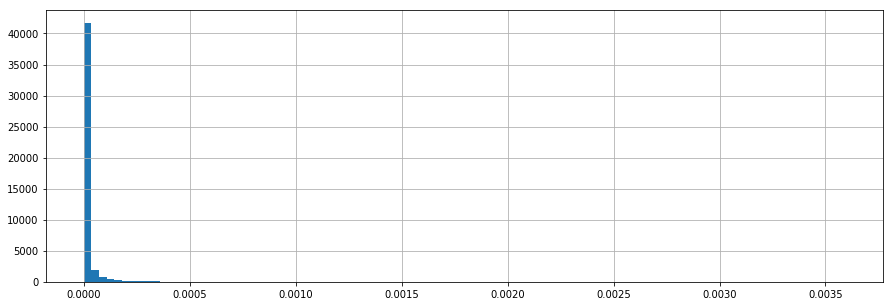

In [138]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

(0, 0.001)

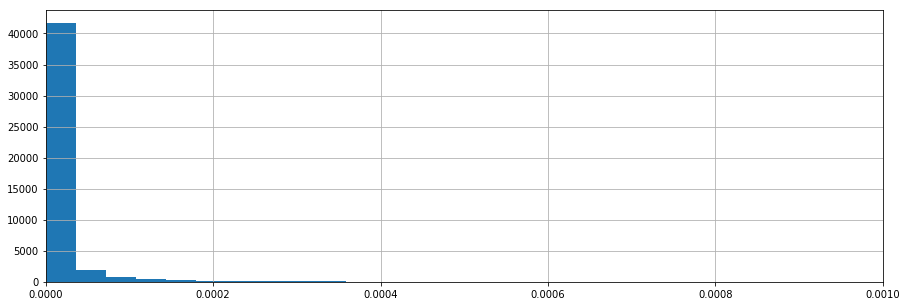

In [139]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.001)

In [140]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=10)).fit(X_train, y_train)

In [142]:
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)

print(X_train_transformed.shape, X_test_transformed.shape)

(270, 714) (90, 714)


In [143]:
predictor_lr_ = LogisticRegression().fit(X_train_transformed, y_train)

In [144]:
y_pred_lr_ = predictor_lr_.predict(X_test_transformed)
print('LR (with feature selection) accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr_), 2)))

LR (with feature selection) accuracy: 0.62%


In [145]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [146]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print('One-VS-all accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.8%


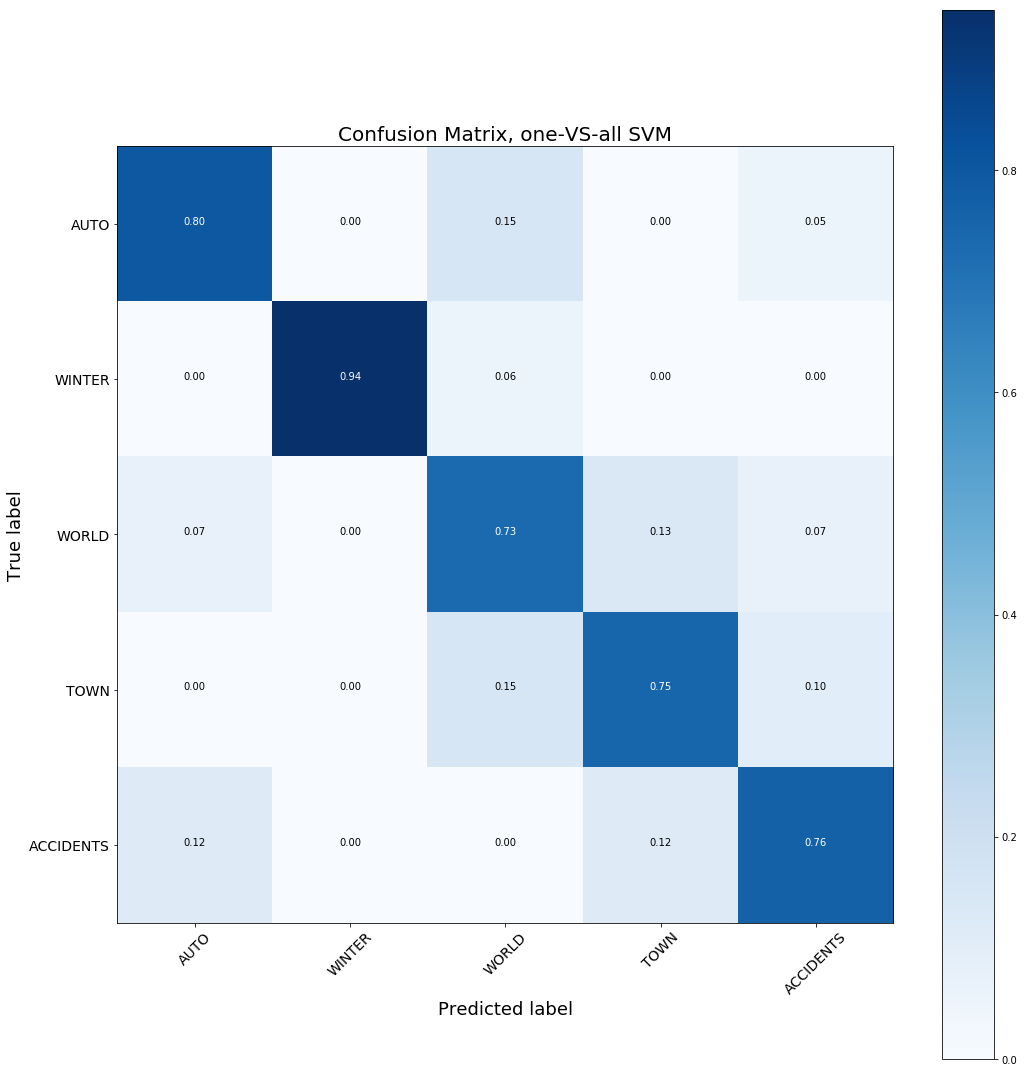

In [147]:
cmt_svm_onevsall = confusion_matrix(y_test, y_pred_onevsall)
plot_confusion_matrix(cmt_svm_onevsall, title='Confusion Matrix, one-VS-all SVM')

In [148]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [150]:

y_pred_onevsone = predictor_oneVSone.predict(X_test)
print('One-VS-one accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsone), 2)))

One-VS-one accuracy: 0.8%


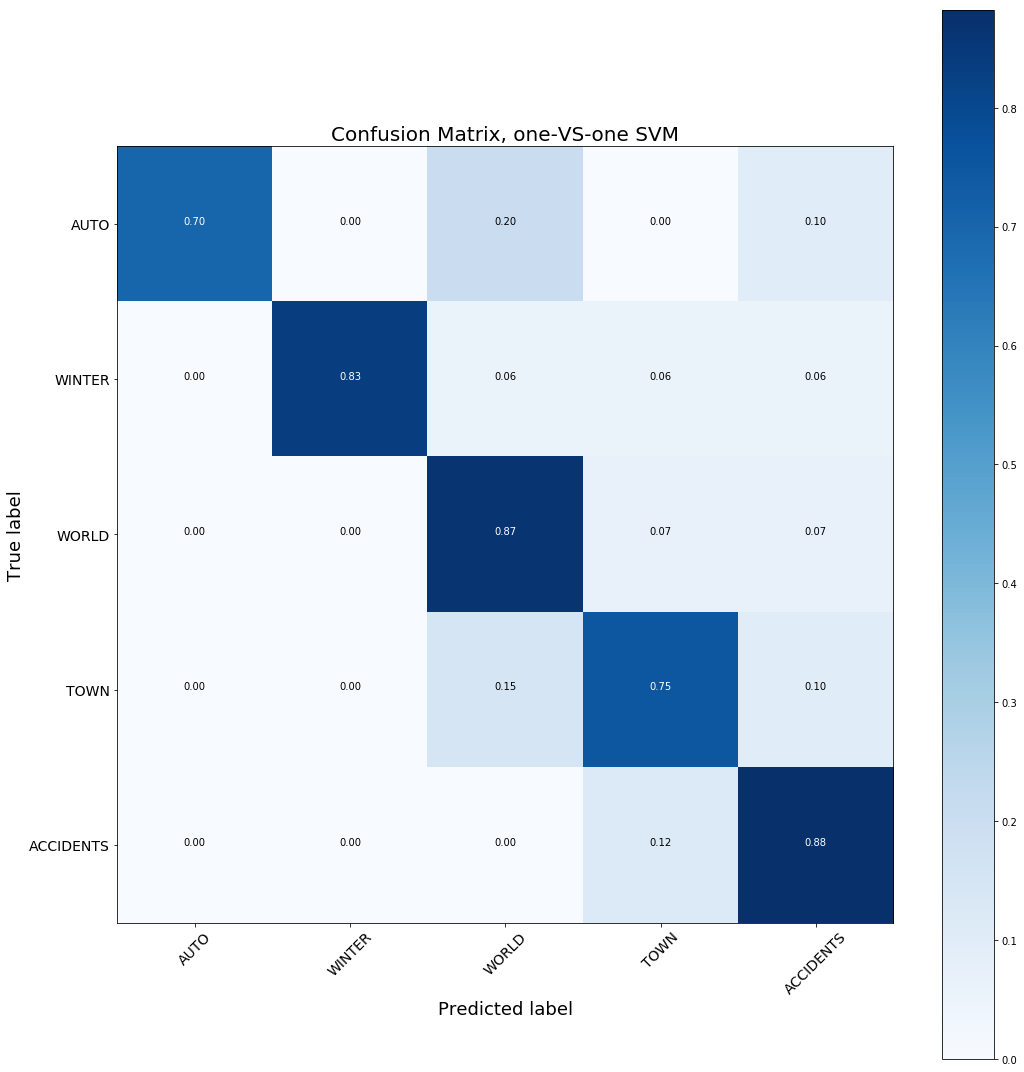

In [151]:
cmt_svm_onevsone = confusion_matrix(y_test, y_pred_onevsone)
plot_confusion_matrix(cmt_svm_onevsone, title='Confusion Matrix, one-VS-one SVM')

In [152]:
for c in np.unique(y_train):
    print('Class \'{}\' samples N: {}'.format(c, y_train[y_train == c].shape[0]))

Class 'ACCIDENTS' samples N: 52
Class 'AUTO' samples N: 54
Class 'TOWN' samples N: 57
Class 'WINTER' samples N: 52
Class 'WORLD' samples N: 55


In [218]:
np.unique(df_test_m["genre"])

array(['ACCIDENTS', 'AUTO', 'TOWN', 'WINTER', 'WORLD'], dtype=object)

In [109]:
#genre_list = ["AUTO", 'WINTER', 'WORLD', 'TOWN', 'ACCIDENTS']
genre_list = [0, 1, 2, 3, 4]
y_train = []
y_test = []
for i in range(1, X_train.shape[0] + 1):
    if i <= 60:
        y_train.append(genre_list[0])
    if 60 < i and i <= 120:
        y_train.append(genre_list[1])
    if 120 < i and i <= 180:
        y_train.append(genre_list[2])
    if 180 < i and i <= 240:
        y_train.append(genre_list[3])
    if 240 < i and i <= 300:
        y_train.append(genre_list[4])
        
"""
for i in range(1, X_test.shape[0] + 1):
    if i <= 11:
        y_test.append(genre_list[0])
    if 11 < i and i <= 22:
        y_test.append(genre_list[1])
    if 22 < i and i <= 33:
        y_test.append(genre_list[2])
    if 33 < i and i <= 44:
        y_test.append(genre_list[3])
    if 44 < i and i <= 55:
        y_test.append(genre_list[4])
"""

'\nfor i in range(1, X_test.shape[0] + 1):\n    if i <= 11:\n        y_test.append(genre_list[0])\n    if 11 < i and i <= 22:\n        y_test.append(genre_list[1])\n    if 22 < i and i <= 33:\n        y_test.append(genre_list[2])\n    if 33 < i and i <= 44:\n        y_test.append(genre_list[3])\n    if 44 < i and i <= 55:\n        y_test.append(genre_list[4])\n'

In [264]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [165]:
import os
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [166]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
initial_categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                      'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
                      'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast',
                      'talk.politics.misc', 'talk.religion.misc']

In [171]:
ng_train = fetch_20newsgroups(subset='train', categories=initial_categories, remove=('headers', 'footers', 'quotes'))
print(np.unique(ng_train.target))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [170]:
len(initial_categories)

15

In [279]:
predictor_lr = LogisticRegression().fit_transform(X_train, y_train)

AttributeError: 'LogisticRegression' object has no attribute 'fit_transform'

In [278]:
predictor_svm = LinearSVC().fit(X_train, y_train)

ValueError: could not convert string to float: '–ù–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ ¬´–¥–ª—è –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏–π¬ª –º—ã –æ—Ç–ø—Ä–∞–≤–∏–ª–∏—Å—å –≤ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏–µ –∏ –ø–æ–Ω—è–ª–∏, —á—Ç–æ —Ä–∞–∑–º–µ—Ä –Ω–µ –≤—Å–µ–≥–¥–∞ –≤—ã–≥–æ–¥–µ–Ω –ù–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ ¬´–¥–ª—è –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏–π¬ª –º—ã –æ—Ç–ø—Ä–∞–≤–∏–ª–∏—Å—å –≤ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏–µ –∏ –ø–æ–Ω—è–ª–∏, —á—Ç–æ —Ä–∞–∑–º–µ—Ä –Ω–µ –≤—Å–µ–≥–¥–∞ –≤—ã–≥–æ–¥–µ–Ω –ß—Ç–æ —Ç–∞–∫–æ–µ –Ω–µ—Å–≤–æ–±–æ–¥–∞, –æ—Ç—á–µ—Ç–ª–∏–≤–µ–µ –≤—Å–µ–≥–æ –ø–æ–Ω–∏–º–∞–µ—à—å –≤ —Å–≤–æ–±–æ–¥–Ω–æ–π –ï–≤—Ä–æ–ø–µ. –ù–µ—Å–≤–æ–±–æ–¥—É –∑–¥–µ—Å—å –æ—â—É—â–∞–µ—à—å —Ñ–∏–∑–∏—á–µ—Å–∫–∏, –ø—ã—Ç–∞—è—Å—å –≤—Ç–∏—Å–Ω—É—Ç—å—Å—è –≤ —â–µ–ª—å –ø–æ–¥–∑–µ–º–Ω–æ–π –ø–∞—Ä–∫–æ–≤–∫–∏ –Ω–∞—Å—Ç–æ–ª—å–∫–æ —É–∑–∫—É—é, —á—Ç–æ –∏–Ω—Å—Ç–∏–Ω–∫—Ç–∏–≤–Ω–æ –ø—Ä–∏–∂–∏–º–∞–µ—à—å –ª–æ–∫—Ç–∏. –ó–µ—Ä–∫–∞–ª–æ –∞–≤—Ç–æ–º–æ–±–∏–ª—è –ø—Ä–æ—Ö–æ–¥–∏—Ç –≤ —Å–∞–Ω—Ç–∏–º–µ—Ç—Ä–µ –æ—Ç —Å—Ç–µ–Ω—ã, –∞ –≤–∑–≥–ª—è–¥ —É–ø–∏—Ä–∞–µ—Ç—Å—è –≤ —Ç–∞–±–ª–∏—á–∫—É ¬´37 –µ–≤—Ä–æ¬ª, –∫–æ—Ç–æ—Ä–∞—è –æ–∑–Ω–∞—á–∞–µ—Ç —Ç–æ –ª–∏ —Å—É—Ç–æ—á–Ω—É—é –ø–ª–∞—Ç—É, —Ç–æ –ª–∏ —à—Ç—Ä–∞—Ñ –≤ —Å–ª—É—á–∞–µ –æ—Ç–∫–∞–∑–∞ –ø–ª–∞—Ç–∏—Ç—å. –ù—É –µ–≥–æ. –ú—ã –ø—è—Ç–∏–º—Å—è –Ω–∞–∑–∞–¥, –≤—Å—ë —Ç–∞–∫–∂–µ –ø—Ä–∏–∂–∏–º–∞—è –ª–æ–∫—Ç–∏ –∏, –Ω–∞ –≤—Å—è–∫–∏–π —Å–ª—É—á–∞–π, –≤—Ç—è–≥–∏–≤–∞—è —â—ë–∫–∏. –°–Ω–∞—Ä—É–∂–∏ –∫–∞–∂–µ—Ç—Å—è, —á—Ç–æ –≤—Å—ë –Ω–µ —Ç–∞–∫ —Å—Ç—Ä–∞—à–Ω–æ... —É–∑–∫–æ ... –Ω–æ –∏–∑–Ω—É—Ç—Ä–∏ –æ—â—É—â–∞–µ—à—å –±—É–¥—Ç–æ –≤–æ—Ç-–≤–æ—Ç —Å–Ω–∏–º–µ—à—å —Å–∫–∞–ª—å–ø —Å–æ —Å—Ç–µ–Ω. –°—É–¥—è –ø–æ –æ—Ç–º–µ—Ç–∏–Ω–∞–º, –ø—Ä–µ—Ü–µ–¥–µ–Ω—Ç—ã –±—ã–ª–∏ –¢–æ, —á—Ç–æ –∞–≤—Ç–æ–º–æ–±–∏–ª—è–º —Ä–∞–∑–º–µ—Ä–æ–º —Å–æ SKODA Kodiaq –≤ –ë–∞—Ä—Å–µ–ª–æ–Ω–µ –∏ –µ—ë –æ–∫—Ä–µ—Å—Ç–Ω–æ—Å—Ç—è—Ö –Ω–µ –æ—á–µ–Ω—å —Ä–∞–¥—ã, —Ö–æ—Ä–æ—à–æ –ø–æ–Ω–∏–º–∞–µ—à—å, –æ—Ç—ã—Å–∫–∞–≤-—Ç–∞–∫–∏ —Å–Ω–æ—Å–Ω—É—é –ø–∞—Ä–∫–æ–≤–∫—É (—Ç—Ä–∏ –µ–≤—Ä–æ –≤ —á–∞—Å), –∫–æ—Ç–æ—Ä–∞—è –≤—ã–≥–ª—è–¥–∏—Ç —Ç–µ—Å–Ω–æ–≤–∞—Ç–æ–π –¥–∞–∂–µ –¥–ª—è Daewoo Matiz. –ï—Å–ª–∏ —É–º—É–¥—Ä–∏—à—å—Å—è –≤—Å—Ç–∞—Ç—å —Ä–æ–≤–Ω–æ, –Ω–µ –æ—Ç–∫—Ä–æ–µ—à—å –¥–≤–µ—Ä–∏, –∏ –Ω–∞–æ–±–æ—Ä–æ—Ç. –¢–∞–∫ –Ω–∞—á–∞–ª–æ—Å—å –º–æ—ë –∑–Ω–∞–∫–æ–º—Å—Ç–≤–æ —Å Kodiaq —Ä–æ—Å—Å–∏–π—Å–∫–æ–π —Å–±–æ—Ä–∫–∏, –∫–æ—Ç–æ—Ä–æ–µ, –≤–æ–ø—Ä–µ–∫–∏ –æ–∂–∏–¥–∞–Ω–∏—è–º, –ø—Ä–æ—à–ª–æ –≤ –ø–æ–ª–Ω–æ–π –∏–Ω—Ç—Ä–∏–≥ –∏ –∑–∞–≥–æ–≤–æ—Ä–æ–≤ —Å—Ç–æ–ª–∏—Ü–µ –ö–∞—Ç–∞–ª–æ–Ω–∏–∏. –ß—Ç–æ —Å–ø—Ä–∞–≤–∞, —á—Ç–æ —Å–ª–µ–≤–∞ ‚Äî –≤–ø—Ä–∏—Ç—ã–∫. –ò —ç—Ç–∞ –ø–∞—Ä–∫–æ–≤–∫–∞ —Å—á–∏—Ç–∞–µ—Ç—Å—è –ø—Ä–æ—Å—Ç–æ—Ä–Ω–æ–π –ü–æ—ç—Ç–æ–º—É –∫–∞–º–µ—Ä–∞ –∑–∞–¥–Ω–µ–≥–æ –≤–∏–¥–∞ –∏ –∫—Ä—É–≥–æ–≤–æ–π ¬´–ø–∞—Ä–∫—Ç—Ä–æ–Ω–∏–∫¬ª –Ω–µ —è–≤–ª—è—é—Ç—Å—è –∑–¥–µ—Å—å –∏–∑–ª–∏—à–µ—Å—Ç–≤–æ–º. –¢–µ–º –±–æ–ª–µ–µ —Å–≤–∏—Ä–µ–ø—ã–µ –∫–∞—Ç–∞–ª–æ–Ω—Ü—ã –¥–∞–∂–µ –≤ –ø—Ä–æ–±–∫–∞—Ö –ø—Ä–∏—Ç–∏—Ä–∞—é—Ç—Å—è —Ç–∞–∫, —á—Ç–æ –ø–∞—Ä–∫—Ç—Ä–æ–Ω–∏–∫ –∏–∑–¥–∞–µ—Ç –∑–∞—Ç—è–∂–Ω–æ–π –ø–∏—Å–∫ –∏ –≤–ø–∞–¥–∞–µ—Ç –≤ –∫–æ–º—É. –û–Ω–∏ –±—ã, –Ω–∞–≤–µ—Ä–Ω–æ–µ, –µ—Ö–∞–ª–∏ –¥–æ –∫–æ–Ω—Ç–∞–∫—Ç–∞, –Ω–æ –º–æ—Å–∫–æ–≤—Å–∫–∏–µ –Ω–æ–º–µ—Ä–∞ –Ω–∞—à–µ–≥–æ Kodiaq –¥–µ–π—Å—Ç–≤—É—é—Ç, –∫–∞–∫ —á–µ—Å–Ω–æ–∫ –Ω–∞ –≤–∞–º–ø–∏—Ä–æ–≤. –ù–∞—à–∞ –ø–µ—Ä–≤–∞—è —Ü–µ–ª—å: —Ö—Ä–∞–º Sagrada Familia –Ω–∞—á–∞–ª–∏ —Å—Ç—Ä–æ–∏—Ç—å –≤ 1882 –≥–æ–¥—É, –∞ –∑–∞–∫–æ–Ω—á–∞—Ç, –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ, –≤ 2026 –≥–æ–¥—É, —á–µ—Ä–µ–∑ —Å—Ç–æ –ª–µ—Ç –ø–æ—Å–ª–µ —Å–º–µ—Ä—Ç–∏ –ê–Ω—Ç–æ–Ω–∏–æ –ì–∞—É–¥–∏ –ö–æ–Ω–µ—á–Ω–æ, –º—ã –Ω–µ –º–æ–≥–ª–∏ —É–ø—É—Å—Ç–∏—Ç—å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –∑–∞–π—Ç–∏ –≤–Ω—É—Ç—Ä—å –ü—ã—Ç–∫—É —Ç–µ—Å–Ω–æ—Ç–æ–π –æ–ø—Ä–∞–≤–¥–∞–ª –≤–∏–¥ —Ñ–∞–Ω—Ç–∞—Å—Ç–∏—á–µ—Å–∫–æ–≥–æ —Ö—Ä–∞–º–∞ Sagrada Familia, –æ—Ç –∫–æ—Ç–æ—Ä–æ–≥–æ –º–æ–π –Ω–∞–ø–∞—Ä–Ω–∏–∫ –∏—Å—Ç–æ—Ä–≥ —Ä–µ—á–∏—Ç–∞—Ç–∏–≤, –≤ –Ω–∞—à–∏—Ö –∫—Ä–∞—è—Ö –æ–∑–Ω–∞—á–∞—é—â–∏–π –≤–æ—Å—Ö–∏—â–µ–Ω–∏–µ –Ω–∞ –≥—Ä–∞–Ω–∏ —Ä–µ–ª–∏–≥–∏–æ–∑–Ω–æ–≥–æ –≤–æ—Å—Ç–æ—Ä–≥–∞. –¢–æ, —á—Ç–æ –∏–∑–¥–∞–ª–µ–∫–∞ –∫–∞–∑–∞–ª–æ—Å—å —à–µ—Ä–æ—Ö–æ–≤–∞—Ç–æ—Å—Ç—å—é, –ø—Ä–∏ –±–ª–∏–∂–∞–π—à–µ–º —Ä–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–∏–∏ –ø—Ä–µ–¥—Å—Ç–∞–ª–æ –º–∏–Ω–∏–∞—Ç—é—Ä–Ω—ã–º–∏ (–≤ —á–µ–ª–æ–≤–µ—á–µ—Å–∫–∏–π —Ä–æ—Å—Ç) —Ñ—Ä–µ—Å–∫–∞–º–∏. –ì–ª—è–¥—è –Ω–∞ ¬´–°–∞–≥—Ä–∞–¥—É¬ª, —Ö–æ—Ä–æ—à–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—à—å, –∫–∞–∫ —Ä–∞—Å–∫–∞–ª—ë–Ω–Ω—ã–π –º–∞—Ö–æ–≤–∏–∫ —Ñ–∞–Ω—Ç–∞–∑–∏–∏ –ê–Ω—Ç–æ–Ω–∏–æ –ì–∞—É–¥–∏ –Ω–∞—Å–ª–∞–∏–≤–∞–ª –ø–æ–≤–µ—Ä—Ö –≤—Å—ë –Ω–æ–≤—ã–µ –∏ –Ω–æ–≤—ã–µ —Å–ª–æ–∏ ‚Äî —ç—Ç–æ –ø—Ä–æ–∏–∑–≤–µ–¥–µ–Ω–∏–µ —Å–ª–æ–∂–Ω–æ –Ω–∞–∑–≤–∞—Ç—å –∑–¥–∞–Ω–∏–µ–º, —Å–∫–æ—Ä–µ–µ, —ç—Ç–æ –≤—ã–±–∏—Ç–æ–µ –≤ –∫–∞–º–Ω–µ –∫–∏–ø–µ–Ω–∏–µ —Ä–µ–ª–∏–≥–∏–æ–∑–Ω–æ–≥–æ —Å–Ω–∞. –ö–æ–ª—å—è –±–∞—à–µ–Ω–Ω—ã—Ö –∫—Ä–∞–Ω–æ–≤, –ø—Ä–æ—Ç—ã–∫–∞—é—â–∏—Ö —Ö—Ä–∞–º –ø—Ä–∏–º–µ—Ä–Ω–æ –ø–æ—Å—Ä–µ–¥–∏–Ω–µ, –ª–∏—à—å –ø–æ–¥—á–µ—Ä–∫–∏–≤–∞—é—Ç –µ–≥–æ –Ω–µ—á–µ–ª–æ–≤–µ—á–µ—Å–∫–∏–π –º–∞—Å—à—Ç–∞–±. –ë–æ–ª—å—à–∞—è —á–∞—Å—Ç—å –¥–æ—Ä–æ–≥ –æ–≥–æ—Ä–æ–∂–µ–Ω–∞ –±–∞—Ä—å–µ—Ä–æ–º, –Ω–æ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –∏ –∑–∞–º–∞–Ω—á–∏–≤—ã–µ –±—Ä–µ—à–∏ –ê –∫—Ä—É–≥–æ–º ‚Äî –ª–µ–ø–æ—Ç–∞ –∏ –ø–ª—é—Å 15 –ø–æ –¶–µ–ª—å—Å–∏—é –ö–∞—Ç–∞–ª–æ–Ω–∏—è ‚Äî —Å–∞–º—ã–π –±–æ–≥–∞—Ç—ã–π —Ä–µ–≥–∏–æ–Ω –ò—Å–ø–∞–Ω–∏–∏, –ø–æ—ç—Ç–æ–º—É –¥–æ—Ä–æ–≥–∏ –∑–¥–µ—Å—å –ª–∏—à–µ–Ω—ã —é–∂–Ω–æ–≥–æ –∫–æ–ª–æ—Ä–∏—Ç–∞ –∏ —Ç–≤–æ—Ä—á–µ—Å–∫–æ–π —â–µ—Ä–±–∞—Ç–æ—Å—Ç–∏. –û–Ω–∏ –Ω–∞—Å—Ç–æ–ª—å–∫–æ —Ö–æ—Ä–æ—à–∏–µ –∏ –Ω–∞—Å—Ç–æ–ª—å–∫–æ –ø–ª–∞—Ç–Ω—ã–µ, —á—Ç–æ –±–æ–ª—å—à—É—é —á–∞—Å—Ç—å –≤—Ä–µ–º–µ–Ω–∏ –Ω–∞ –∞–≤—Ç–æ–º–∞–≥–∏—Å—Ç—Ä–∞–ª—è—Ö –≤—ã–∫–æ–≤—ã—Ä–∏–≤–∞–µ—à—å –∏–∑ –∑—É–±–æ–≤ —Ö–∞–º–æ–Ω –∏ —É–≤–æ—Ä–∞—á–∏–≤–∞–µ—à—å—Å—è –æ—Ç –ª–µ—Ç—è—â–∏—Ö –ø–æ–∑–∞–¥–∏ –∏—Å–ø–∞–Ω—Ü–µ–≤, –∫–æ—Ç–æ—Ä—ã–µ —á—Ç—è—Ç –ª–∏–º–∏—Ç—ã —Å–∫–æ—Ä–æ—Å—Ç–∏ —á—É—Ç—å –º–µ–Ω—å—à–µ, —á–µ–º —Ñ—É—Ç–±–æ–ª—å–Ω—ã–π –∫–ª—É–± ¬´–ë–∞—Ä—Å–µ–ª–æ–Ω–∞¬ª. –î–æ—Ä–æ–≥–∏ –≤ –ò—Å–ø–∞–Ω–∏–∏ –ø—Ä–µ–∫—Ä–∞—Å–Ω—ã–µ –¥–æ —Ç–∞–∫–æ–π —Å—Ç–µ–ø–µ–Ω–∏, —á—Ç–æ –∞–∂ –∑–ª–æ –±–µ—Ä—ë—Ç –ù–æ –º–Ω–æ–≥–æ –ø–ª–∞—Ç–Ω—ã—Ö. –ù–∞–ø—Ä–∏–º–µ—Ä, –∑–∞ 350 –∫–∏–ª–æ–º–µ—Ç—Ä–æ–≤ –æ—Ç –ë–∞—Ä—Å–µ–ª–æ–Ω—ã –¥–æ –í–∞–ª–µ–Ω—Å–∏–∏ –ø–æ–ø—Ä–æ—Å—è—Ç 41 –µ–≤—Ä–æ ‚Äî –±–æ–ª–µ–µ 3000 —Ä—É–±–ª–µ–π –ö–æ–Ω–µ—á–Ω–æ, —ç—Ç–æ–π —Ä–∞—Å—Å–ª–∞–±–ª–µ–Ω–Ω–æ—Å—Ç–∏ –¥–æ–±–∞–≤–ª—è–µ—Ç –∏ —Å–∞–º Kodiaq, –∫–æ—Ç–æ—Ä—ã–π –ø–æ —à–∫–æ–¥–æ–≤—Å–∫–∏–º –º–µ—Ä–∫–∞–º —è–≤–ª—è–µ—Ç—Å—è –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–º –º—è–≥–∫–∏–º –∏ –¥–∞–∂–µ –∫–∞–∫ –±—É–¥—Ç–æ —á–µ—Ä–µ—Å—á—É—Ä. –ù–∞ –∏—Å–ø–∞–Ω—Å–∫–∏—Ö –¥–æ—Ä–æ–≥–∞—Ö –æ–Ω –µ–¥–µ—Ç, –∑–∞–¥–µ—Ä–∂–∞–≤ –¥—ã—Ö–∞–Ω–∏–µ, –ø–æ—Ç–æ–º—É —á—Ç–æ –¥–ª—è –≤–∑–¥–æ—Ö–æ–≤ –Ω–µ—Ç –Ω–∏ –æ–¥–Ω–æ–π –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ–π –∫–æ—á–∫–∏. –î–∞–∂–µ –≥—Ä—É–Ω—Ç–æ–≤–∫–∏ —Å–ª–æ–≤–Ω–æ —É—Ç—Ä–∞–º–±–æ–≤–∞–ª–∏ –∫–∞—Ç–∫–æ–º Kodiaq –∑–¥–æ—Ä–æ–≤–æ —Å–∫—Ä–∞–¥—ã–≤–∞–µ—Ç –æ—â—É—â–µ–Ω–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏, –ø–æ—ç—Ç–æ–º—É —É–º–Ω—ã–π –∫—Ä—É–∏–∑-–∫–æ–Ω—Ç—Ä–æ–ª—å ‚Äî —Å–æ–≤—Å–µ–º –Ω–µ –ª–∏—à–Ω–µ–µ –∏–∑–æ–±—Ä–µ—Ç–µ–Ω–∏–µ –ú—ã –¥–≤–∏–∂–µ–º—Å—è –≤ —Å—Ç–æ—Ä–æ–Ω—É –æ–¥–Ω–æ–π –ª—é–±–æ–ø—ã—Ç–Ω–æ–π –≤–∏–Ω–æ–¥–µ–ª—å–Ω–∏, —É–ø–æ–≤–∞—è –±–æ–ª—å—à–∞—è —á–∞—Å—Ç—å—é –Ω–∞ –∞–∫—Ç–∏–≤–Ω—ã–π –∫—Ä—É–∏–∑-–∫–æ–Ω—Ç—Ä–æ–ª—å, –∫–æ—Ç–æ—Ä—ã–π –≤—ã–¥–µ—Ä–∂–∏–≤–∞–µ—Ç —Ä–∞–∑—Ä–µ—à–µ–Ω–Ω—ã–µ 120 –∫–º/—á–∞—Å –∏ —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–æ –ø—Ä–∏—Ç–æ—Ä–º–∞–∂–∏–≤–∞–µ—Ç –ø–µ—Ä–µ–¥ —Ñ—É—Ä–∞–º–∏, –¥–∞ —Ç–∞–∫ —Ö–æ—Ä–æ—à–æ, —á—Ç–æ —á–µ—Ä–µ–∑ –ø–∞—Ä—É —á–∞—Å–æ–≤ –Ω–∞–≤—ã–∫ —Ç–æ—Ä–º–æ–∑–∏—Ç—å –∑–∞–±—ã–≤–∞–µ—Ç—Å—è –Ω–∞–ø—Ä–æ—á—å. –ï–¥–∏–Ω—Å—Ç–≤–µ–Ω–Ω—ã–º –Ω–µ—É–¥–æ–±—Å—Ç–≤–æ–º —è–≤–ª—è–µ—Ç—Å—è –µ–≥–æ –≤–Ω–∏–º–∞–Ω–∏–µ –∫ –∞–≤—Ç–æ–º–æ–±–∏–ª—è–º –Ω–∞ –ø–æ–ª–æ—Å–∞—Ö –¥–ª—è —Ä–∞–∑–≥–æ–Ω–∞ –∏ —Ç–æ—Ä–º–æ–∂–µ–Ω–∏—è, –ø—Ä–∏ –ø–æ–¥—ä–µ–∑–¥–µ –∫ –∫–æ—Ç–æ—Ä—ã–º –æ–Ω –∏–Ω—Ç–µ–Ω—Å–∏–≤–Ω–æ —Ç–æ—Ä–º–æ–∑–∏—Ç, —Ö–æ—Ç—è –ø—Ä–µ–ø—è—Ç—Å—Ç–≤–∏–µ –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ —Ç—Ä–µ—Ö –º–µ—Ç—Ä–∞—Ö –ø—Ä–∞–≤–µ–µ —Ç–µ–±—è. –ë–ª–∏–∑ –ë–∞—Ä—Å–µ–ª–æ–Ω—ã –º–Ω–æ–≥–æ –ø–æ—Ç—Ä—è—Å–∞—é—â–∏—Ö –≥–æ—Ä–Ω—ã—Ö –¥–æ—Ä–æ–≥, –∫–æ—Ç–æ—Ä—ã–µ —É–±–∏–≤–∞—é—Ç –∂–µ—Å—Ç–∫–∏–µ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è —Å–∫–æ—Ä–æ—Å—Ç–∏ –ú—è–≥–∫–æ—Å—Ç—å Kodiaq —Ö–æ—Ä–æ—à–æ –∑–∞–º–µ—Ç–Ω–∞ –Ω–∞ –∫—Ä—É–∂–µ–≤–Ω—ã—Ö —Å–µ—Ä–ø–∞–Ω—Ç–∏–Ω–∞—Ö –ö–∞—Ç–∞–ª–æ–Ω—Å–∫–∏—Ö –≥–æ—Ä. –•–æ—Ç—è –ø–æ –º–µ—Ä–∫–∞–º –∫—Ä–æ—Å—Å–æ–≤–µ—Ä–æ–≤ –æ–Ω –≤–µ—Å—å–º–∞ —Ç–æ—á–µ–Ω, Octavia –∏ Superb –≤—Å—ë –∂–µ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ. –£ –Ω–∏—Ö –ª—É—á—à–µ –æ—Ç–∫–ª–∏–∫ –≤ –Ω–∞—á–∞–ª—å–Ω–æ–π —Ñ–∞–∑–µ –∏ –±–æ–ª—å—à–µ –∑–ª–æ—Å—Ç–∏ –≤ –æ—Ç–≤–µ—Ç –Ω–∞ —É—Å–∫–æ—Ä–µ–Ω–∏–µ –ø–æ—Å—Ä–µ–¥–∏ –ø–æ–≤–æ—Ä–æ—Ç–∞: –µ—Å–ª–∏ —Ç–æ—Ç –∂–µ Superb –≥—Ä—ã–∑—ë—Ç –∞—Å—Ñ–∞–ª—å—Ç –∏ —Å—Ç—Ä–µ–º–∏—Ç—Å—è –≤–Ω—É—Ç—Ä—å, Kodiaq –Ω–æ—Ä–æ–≤–∏—Ç –∑–∞—Å–≤–∏—Å—Ç–µ—Ç—å —à–∏–Ω–∞–º–∏ –∏ –≤—ã—Å–∫–æ–ª—å–∑–Ω—É—Ç—å –Ω–∞—Ä—É–∂—É. –£–π—Ç–∏ –≤—Ä–∞–∑–Ω–æ—Å –µ–º—É –Ω–µ –¥–∞–µ—Ç —Å–∏—Å—Ç–µ–º–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏–∏, –Ω–æ —Å–∞–º —Ö–∞—Ä–∞–∫—Ç–µ—Ä –∞–≤—Ç–æ–º–æ–±–∏–ª—è –Ω–µ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç –≥–æ–Ω–æ–∫. Kodiaq –º–æ–∂–µ—Ç –µ—Ö–∞—Ç—å –±—ã—Å—Ç—Ä–æ –∏ —Ä–µ–∑–∫–æ, –Ω–æ –∏–Ω–∏—Ü–∏–∞—Ç–∏–≤—ã –Ω–µ –ø—Ä–æ—è–≤–ª—è–µ—Ç –∏ –º–∞–ª–æ-–ø–æ–º–∞–ª—É —É—Å–ø–æ–∫–∞–∏–≤–∞–µ—Ç –∏ –≤–æ–¥–∏—Ç–µ–ª—è –ù–µ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞—é—Ç –≥–æ–Ω–æ–∫ –∏ –∫–∞—Ç–∞–ª–æ–Ω—Å–∫–∏–µ –¥–æ—Ä–æ–≥–∏, –∫–æ—Ç–æ—Ä—ã–µ, –ø—Ä–∏–∑–Ω–∞—Ç—å—Å—è, –≤—ã–Ω–∏–º–∞—é—Ç –¥—É—à—É –∞–±—Å—É—Ä–¥–Ω—ã–º–∏ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è–º–∏ —Å–∫–æ—Ä–æ—Å—Ç–∏. –ù—É —Ö–æ—Ä–æ—à–æ ‚Äî –∞–±—Å—É—Ä–¥–Ω—ã–º–∏ —Å —Ç–æ—á–∫–∏ –∑—Ä–µ–Ω–∏—è –Ω–∞—Å, –∑–∞–ª—ë—Ç–Ω—ã—Ö. –ù–æ –≤—Å—ë-—Ç–∞–∫–∏ –æ—Ç –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç–∏ –∫–∞–∂–¥—ã–µ 200 –º–µ—Ç—Ä–æ–≤ —Å–±—Ä–∞—Å—ã–≤–∞—Ç—å —Å–∫–æ—Ä–æ—Å—Ç—å –¥–æ 40 –≤ –¥—É—à–µ –ø—Ä–æ—Å—ã–ø–∞–µ—Ç—Å—è –∫–∞–∫–æ–µ-—Ç–æ —ç–ø–∏–ª–µ–ø—Ç–∏—á–µ—Å–∫–æ–µ —á—É–≤—Å—Ç–≤–æ. –ö —Ç–æ–º—É –∂–µ –¥–æ—Ç–æ—à–Ω–∞—è —Å–∏—Å—Ç–µ–º–∞ –Ω–∞–≤–∏–≥–∞—Ü–∏–∏ Kodiaq –æ—Ç—Ä–∞–∂–∞–µ—Ç –ª–∏–º–∏—Ç—ã —Å–∫–æ—Ä–æ—Å—Ç–∏ –Ω–∞ —ç–∫—Ä–∞–Ω–µ, –Ω–æ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç –∑–Ω–∞–∫ ¬´–†–µ–∫–æ–º–µ–Ω–¥–æ–≤–∞–Ω–Ω–∞—è —Å–∫–æ—Ä–æ—Å—Ç—å¬ª –∑–∞ –∂—ë—Å—Ç–∫–æ–µ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ, —á—Ç–æ –Ω–µ–ø–ª–æ—Ö–æ —Å —Ç–æ—á–∫–∏ –∑—Ä–µ–Ω–∏—è –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏, –Ω–æ –¥–µ–π—Å—Ç–≤—É–µ—Ç –Ω–∞ –Ω–µ—Ä–≤—ã. –°–∫–æ—Ä–æ—Å—Ç–Ω—ã–µ –ª–∏–º–∏—Ç—ã, –≤–ø—Ä–æ—á–µ–º, –æ–ø—Ä–∞–≤–¥–∞–Ω—ã: –¥–æ—Ä–æ–≥–∏ –≤ —Å–∞–º–æ–º –¥–µ–ª–µ –ø—Ä–æ–≤–æ—Ü–∏—Ä—É—é—Ç –ù–µ–≤–æ–∑–º—É—Ç–∏–º—ã–µ –≤–µ–ª–æ—Å–∏–ø–µ–¥–∏—Å—Ç—ã —Ç–∞–∫ –∏ –Ω–µ —É—Å—Ç—É–ø–∏–ª–∏ –ù–æ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è —Å–∫–æ—Ä–æ—Å—Ç–∏ ‚Äî —ç—Ç–æ —Ö–æ—Ç—è –±—ã –≤ –Ω–∞—à–∏—Ö –∏–Ω—Ç–µ—Ä–µ—Å–∞—Ö. –ß—Ç–æ–±—ã –≤—ã –ø–æ–Ω—è–ª–∏ –∫–∞–±–∞–ª—å–Ω–æ—Å—Ç—å –∏—Å–ø–∞–Ω—Å–∫–∏—Ö –∑–∞–∫–æ–Ω–æ–≤, —à—Ç—Ä–∞—Ñ—ã –≤ —Ä–∞–∑–º–µ—Ä–µ 5000‚Äì8000 —Ä—É–±–ª–µ–π –∂–¥—É—Ç –∑–¥–µ—Å—å –∑–∞ –≤–æ–∂–¥–µ–Ω–∏–µ –≤ —à–ª—ë–ø–∞–Ω—Ü–∞—Ö, –µ–∑–¥—É —Å –ª–æ–∫—Ç–µ–º –Ω–∞ ¬´–ø–æ–¥–æ–∫–æ–Ω–Ω–∏–∫–µ¬ª, –ø–æ–µ–¥–∞–Ω–∏–µ –º–æ—Ä–æ–∂–µ–Ω–æ–≥–æ –∏–ª–∏ —Ä–∞—Å–ø–∏—Ç–∏–µ –≤–æ–¥—ã –∑–∞ —Ä—É–ª—ë–º. –°–¥–µ–ª–∞–Ω–æ —ç—Ç–æ, –¥–∞–±—ã –ø–æ–¥ –±–ª–∞–≥–∏–º –ø—Ä–µ–¥–ª–æ–≥–æ–º –≤—ã–¥–æ–∏—Ç—å –¥–æ –Ω–∏—Ç–∫–∏ —Ç—É—Ä–∏—Å—Ç–æ–≤, —á—Ç–æ –Ω–∞–≤–æ–¥–Ω—è—é—Ç –ë–∞—Ä—Å–µ–ª–æ–Ω—É —Å –≤–µ—Å–Ω—ã –ø–æ —Ä–∞–Ω–Ω—é—é –æ—Å–µ–Ω—å. –ü—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç–µ, –∫–∞–∫–æ–µ –∑–ª–æ–≤–æ–Ω–∏–µ –ø–æ–¥–Ω—è–ª–æ—Å—å –±—ã –≤ –†–æ—Å—Å–∏–∏, –µ—Å–ª–∏ –±—ã —É –Ω–∞—Å –∑–∞–ø—Ä–µ—Ç–∏–ª–∏ –ø–∏—Ç—å –∑–∞ —Ä—É–ª—ë–º –≤–æ–¥—É? –ù–µ –≤—Å–µ –µ—â—ë –ø–µ—Ä–µ–≤–∞—Ä–∏–ª–∏ –∑–∞–ø—Ä–µ—Ç –∞–ª–∫–æ–≥–æ–ª—è, –∞ —Ç—É—Ç ‚Äî –≤–æ–¥–∞. –ù–∞–≤–µ—Ä–Ω—è–∫–∞ –µ—ë —É–ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –≥–∞—Ä–∞–Ω—Ç–∏—Ä–æ–≤–∞–Ω–æ –∫–∞–∫–æ–π-–Ω–∏–±—É–¥—å —Å—Ç–∞—Ç—å–µ–π –ö–æ–Ω—Å—Ç–∏—Ç—É—Ü–∏–∏. –û–ø—Ä–µ–¥–µ–ª–∏—Ç—å Kodiaq –º–æ–∂–Ω–æ –≤ –¥–≤—É—Ö —Å–ª–æ–≤–∞—Ö —Å –ø–æ–º–æ—â—å—é —ç–ø–∏—Ç–µ—Ç–æ–≤ ¬´–ø–æ–∫–ª–∞–¥–∏—Å—Ç–æ—Å—Ç—å¬ª –∏ ¬´–ø—Ä–∞–∫—Ç–∏—á–Ω–æ—Å—Ç—å¬ª. –ü–µ—Ä–≤–æ–µ —Ç—ã –ø–æ–Ω–∏–º–∞–µ—à—å –∑–∞ —Ä—É–ª—ë–º, –∏ —Ö–æ—Ä–æ—à–æ —ç—Ç–æ –∏–ª–∏ –ø–ª–æ—Ö–æ, –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –Ω–∞—Å—Ç—Ä–æ—è: –µ—Å–ª–∏ –≤ –∫—Ä–æ–≤–∏ –µ—â—ë –∏–≥—Ä–∞—é—Ç –≥–æ—Ä–º–æ–Ω—ã —Ä–∞–¥–æ—Å—Ç–∏, –Ω—É–∂–Ω–æ –∂–¥–∞—Ç—å –≤–µ—Ä—Å–∏—é Kodiaq RS. –ß—Ç–æ –∫–∞—Å–∞–µ—Ç—Å—è –ø—Ä–∞–∫—Ç–∏—á–Ω–æ—Å—Ç–∏, –≤ –∫–∞–∫–æ–π-—Ç–æ –º–æ–º–µ–Ω—Ç –Ω–∞—á–∏–Ω–∞–µ—à—å –∂–∞–ª–µ—Ç—å, —á—Ç–æ —Å —Ç–æ–±–æ–π –Ω–µ—Ç —Ç–≤–æ–∏—Ö —Å–ø–∏–Ω–æ–≥—Ä—ã–∑–æ–≤ —Å –∏—Ö —Å–∞–º–æ–∫–∞—Ç–∞–º–∏, –≤–µ–ª–∏–∫–∞–º–∏ –∏ —á–µ–º–æ–¥–∞–Ω–æ–º —Å–∞–º–æ–≥–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–≥–æ (–Ω–∞ –¥–≤–∞-—Ç–æ –¥–Ω—è...), —á—Ç–æ–±—ã —â–µ–≥–æ–ª—å–Ω—É—Ç—å –±–∞–≥–∞–∂–Ω–∏–∫–æ–º –Ω–∞ 600 –ª–∏—Ç—Ä–æ–≤. –î–≤–æ–µ –º—É–∂—á–∏–Ω –≤ Kodiaq –æ—â—É—â–∞—é—Ç —Å–µ–±—è —ç—Ç–∞–∫–∏–º–∏ —ë–∂–∏–∫–∞–º–∏ –≤ —Ç—É–º–∞–Ω–µ, –∫–æ—Ç–æ—Ä—ã–µ —Å–∞–º–∏ –Ω–µ –ø–æ–Ω–∏–º–∞—é—Ç, —á—Ç–æ –∏–º –¥–µ–ª–∞—Ç—å —Å —ç—Ç–∏–º –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ–º –≤–æ–∫—Ä—É–≥. –í–µ—á–µ—Ä–∞–º–∏ –∞—Ç–º–æ—Å—Ñ–µ—Ä–∞ —Å—Ç–∞–Ω–æ–≤–∏—Ç—Å—è –ø—Ä–∏–∑—Ä–∞—á–Ω–æ–π –ï—Å–ª–∏, –≤—ã–±–∏—Ä–∞—è Kodiaq, –≤—ã –Ω–µ –º–æ–∂–µ—Ç–µ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å—Å—è —Å –¥–≤–∏–≥–∞—Ç–µ–ª–µ–º, —Ç–æ –≤–æ—Ç –Ω–µ–±–æ–ª—å—à–æ–π –≥–∏–¥. –ú–ª–∞–¥—à–∏–π 125-—Å–∏–ª—å–Ω—ã–π –º–æ—Ç–æ—Ä —è–≤–ª—è–µ—Ç—Å—è –¥–µ—Ñ–æ—Ä—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –≤–µ—Ä—Å–∏–µ–π 150-—Å–∏–ª—å–Ω–æ–≥–æ 1.4 TSI, –∏ –æ–±–∞ –æ–±–µ—Å–ø–µ—á–∏–≤–∞—é—Ç Kodiaq —É–±–µ–¥–∏—Ç–µ–ª—å–Ω—É—é –¥–∏–Ω–∞–º–∏–∫—É ‚Äî —Ä–∞–∑–≥–æ–Ω –¥–æ 100 –∫–º/—á–∞—Å –≤ —Ä–∞–π–æ–Ω–µ 10 —Å–µ–∫—É–Ω–¥. –û–Ω–∏ —è–≤–ª—è—é—Ç—Å—è –≤–ø–æ–ª–Ω–µ –∑–¥—Ä–∞–≤—ã–º –≤—ã–±–æ—Ä–æ–º –¥–ª—è –∞–≤—Ç–æ–º–æ–±–∏–ª—è, –∫–æ—Ç–æ—Ä—ã–π –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤ –≥–æ—Ä–æ–¥–µ. –û–±–∞ –º–æ—Ç–æ—Ä–∞ –æ—Ç–Ω–æ—Å—è—Ç—Å—è –∫ —Å–µ–º–µ–π—Å—Ç–≤—É EA211, –∫–æ—Ç–æ—Ä–æ–µ –æ—Ç–ª–∏—á–∞–µ—Ç—Å—è –æ—Ç –ø–µ—Ä–≤–æ–π –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –º–æ—Ç–æ—Ä–æ–º TSI –≤–µ—Å—å–º–∞ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ. –î–ª—è –º–µ–∂–≥–æ—Ä–æ–¥–∞ –ø—Ä–µ–¥–ø–æ—á—Ç–∏—Ç–µ–ª—å–Ω–µ–µ 2-–ª–∏—Ç—Ä–æ–≤—ã–π 180-—Å–∏–ª—å–Ω—ã–π —Ç—É—Ä–±–æ–º–æ—Ç–æ—Ä, –∫–æ—Ç–æ—Ä—ã–π —Å–Ω–∏–º–∞–µ—Ç —Å –≤—Ä–µ–º–µ–Ω–∏ —Ä–∞–∑–≥–æ–Ω–∞ –ø–∞—Ä—É —Å–µ–∫—É–Ω–¥ –∏ –∏–º–µ–µ—Ç –±–æ–ª–µ–µ ¬´–º—è—Å–∏—Å—Ç—É—é¬ª —Å–µ—Ä–µ–¥–∏–Ω—É —Ä–∞–±–æ—á–µ–≥–æ –¥–∏–∞–ø–∞–∑–æ–Ω–∞, –ø–æ–∑–≤–æ–ª—è—è –æ–±–≥–æ–Ω—è—Ç—å –∑–∞—Å—ã–ø–∞—é—â–∏—Ö –∏—Å–ø–∞–Ω—Å–∫–∏—Ö —Ñ–µ—Ä–º–µ—Ä–æ–≤ –æ–¥–Ω–∏–º —â–µ–ª—á–∫–æ–º –∫–Ω—É—Ç–∞. –ù–∞–∏–±–æ–ª–µ–µ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –¥–ª—è –†–æ—Å—Å–∏–∏ –¥–≤–∏–≥–∞—Ç–µ–ª—å ‚Äî 2.0 TSI (180 –ª. —Å.) –ß—Ç–æ –¥–æ –¥–∏–∑–µ–ª—è, –æ–Ω –æ–ø—Ä–∞–≤–¥–∞–Ω –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –¥–ª—è –Ω–∞—Å—Ç–æ—è—â–∏—Ö –ø—É—Ç–µ—à–µ—Å—Ç–≤–µ–Ω–Ω–∏–∫–æ–≤: –ø–æ –Ω–∞—à–∏–º –æ—Ü–µ–Ω–∫–∞–º, –æ–∫—É–ø–∞–µ–º–æ—Å—Ç—å –Ω–∞—Å—Ç—É–ø–∞–µ—Ç —á–µ—Ä–µ–∑ 150 —Ç—ã—Å—è—á –∫–∏–ª–æ–º–µ—Ç—Ä–æ–≤. –ü—Ä–∏ —ç—Ç–æ–º –¥–∏–Ω–∞–º–∏–∫–∞ –¥–∏–∑–µ–ª—è –≤—Å—ë –∂–µ —É—Å—Ç—É–ø–∞–µ—Ç –±–µ–Ω–∑–∏–Ω–æ–≤–æ–º—É –≤–∞—Ä–∏–∞–Ω—Ç—É, –ø–æ—ç—Ç–æ–º—É –¥–ª—è –†–æ—Å—Å–∏–∏ –∑–æ–ª–æ—Ç–æ–π —Å–µ—Ä–µ–¥–∏–Ω–æ–π —è–≤–ª—è–µ—Ç—Å—è –∏–º–µ–Ω–Ω–æ –ø–æ—Å–ª–µ–¥–Ω–∏–π. –ö—Å—Ç–∞—Ç–∏, Kodiaq —Å –¥–≤—É—Ö–ª–∏—Ç—Ä–æ–≤—ã–º –º–æ—Ç–æ—Ä–æ–º –æ—Å–Ω–∞—â–∞–µ—Ç—Å—è –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –Ω–æ–≤—ã–º —Å–µ–º–∏—Å—Ç—É–ø–µ–Ω—á–∞—Ç—ã–º ¬´—Ä–æ–±–æ—Ç–æ–º¬ª DQ500, –∫–æ—Ç–æ—Ä—ã–π –∑–∞ —Å—á—ë—Ç ¬´–º–æ–∫—Ä–æ–≥–æ¬ª —Å—Ü–µ–ø–ª–µ–Ω–∏—è –º—è–≥–∫–æ—Å—Ç—å—é —Å—Ç–∞—Ä—Ç–∞ –Ω–∞–ø–æ–º–∏–Ω–∞–µ—Ç –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏–π ¬´–∞–≤—Ç–æ–º–∞—Ç¬ª, –∞ –≤ –æ—Å—Ç–∞–ª—å–Ω–æ–µ –≤—Ä–µ–º—è ‚Äî —Ç–∏–ø–∏—á–Ω—É—é –∫–æ—Ä–æ–±–∫—É DSG —Å –µ—ë –±–µ—Å—à–æ–≤–Ω—ã–º —Ö–∞—Ä–∞–∫—Ç–µ—Ä–æ–º –ø–µ—Ä–µ–∫–ª—é—á–µ–Ω–∏—è. –í –µ–¥–≤–∞ –∑–∞–º–µ—Ç–Ω–æ–π –ª–µ–Ω–æ—Å—Ç–∏, —Å –∫–æ—Ç–æ—Ä–æ–π Kodiaq —Ç—Ä–æ–≥–∞–µ—Ç—Å—è —Å –º–µ—Å—Ç–∞, —Ç–æ–∂–µ –µ—Å—Ç—å —á—Ç–æ-—Ç–æ —Ç–∏–ø–∏—á–Ω–æ ¬´–∫–æ–¥–∏–∞–∫–æ–≤—Å–∫–æ–µ¬ª: –≤—Å–µ –æ—Å—Ç—Ä—ã–µ —É–≥–ª—ã SKODA –æ—Å—Ç–∞–≤–∏–ª–∞ –¥–ª—è –µ–≥–æ –¥–∏–∑–∞–π–Ω–∞, –Ω–æ –Ω–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∞. –ñ—ë–ª—Ç–∞—è –ª–µ–Ω—Ç–∞ –Ω–∞ –¥–æ–º–µ ‚Äî —Å–∏–º–≤–æ–ª –Ω–µ–∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –ß—Ç–æ –∫–∞—Å–∞–µ—Ç—Å—è —Å–≤–æ–±–æ–¥—ã, —Ç–æ —É –ö–∞—Ç–∞–ª–æ–Ω–∏–∏ —Å–≤–æ–∏ –∏–¥–µ–∞–ª—ã. –û–Ω–∞ –∫—É—Ç–∞–µ—Ç—Å—è –≤ –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–π —Ñ–ª–∞–≥ –∏ –≥—Ä–µ–∑–∏—Ç –Ω–µ–∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å—é –æ—Ç –ò—Å–ø–∞–Ω–∏–∏. –ó–Ω–∞–∫–∏ —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏—è –≤ –≤–∏–¥–µ –∂—ë–ª—Ç–æ–π –ª–µ–Ω—Ç–æ—á–∫–∏ –≤–∏–¥–Ω—ã –ø–æ –≤—Å–µ–π –æ–∫—Ä—É–≥–µ ‚Äî –¥–∞–∂–µ –Ω–∞ –∞—Å—Ñ–∞–ª—å—Ç–µ –∞–≤—Ç–æ–±–∞–Ω–æ–≤. –°–∫–∞–ª—ã –≤–µ–¥—É—Ç –Ω–µ—Ä–∞–≤–Ω—ã–π –±–æ–π —Å –∑–µ–ª–µ–Ω—å—é: —Ç–∞–∫–æ–π –ø–µ–π–∑–∞–∂ —Ç–∏–ø–∏—á–µ–Ω –¥–ª—è –°—Ä–µ–¥–∏–∑–µ–º–Ω–æ–º–æ—Ä—å—è –û—á–µ–Ω—å –º—Ä–∞—á–Ω—ã–π –≥–æ—Ä–æ–¥ –≥–¥–µ-—Ç–æ –ø–æ –ø—É—Ç–∏ –≤ –≤–∏–Ω–æ–¥–µ–ª—å–Ω—é –ß–∞—Å–æ–≤–Ω—è –∏ –∫–ª–∞–¥–±–∏—â–µ: –∑–¥–µ—Å—å –æ—á–µ–Ω—å —Ç–∏—Ö–æ –∏ —É–µ–¥–∏–Ω–µ–Ω–Ω–æ, –ø–æ—ç—Ç–æ–º—É —Ö–æ—á–µ—Ç—Å—è –ø—Ä–æ—Å—Ç–æ –ø–æ—Å–∏–¥–µ—Ç—å –∏ –∑–∞–±—ã—Ç—å –æ –≥—Ä–∞—Ñ–∏–∫–µ –ú–Ω–æ–≥–∏–µ –≥–æ—Ä–æ–¥–∫–∏ –≤—ã–≥–ª—è–¥—è—Ç –≤–æ—Ç —Ç–∞–∫ ‚Äî –±–µ–∑–ª–∏–∫–æ. –í –Ω–∏—Ö –º–∞–ª–æ –º–∞—à–∏–Ω, –∞ –ø–æ–¥ –≤–µ—á–µ—Ä –º–∞–ª–æ –∏ –ª—é–¥–µ–π, —Ç–∞–∫ —á—Ç–æ –∞—Ç–º–æ—Å—Ñ–µ—Ä–∞ –Ω–µ—Å–∫–æ–ª—å–∫–æ –≥–Ω–µ—Ç—É—â–∞—è –¢–∞–∫–∏–µ –∑–¥–∞–Ω–∏—è –ø–æ—á–µ–º—É-—Ç–æ –Ω–∞–ø–æ–º–∏–Ω–∞—é—Ç –º–Ω–µ —Å–∫–∞–∑–∫—É –æ –ß–∏–ø–æ–ª–ª–∏–Ω–æ, —Ö–æ—Ç—è –æ–Ω —Ä–æ–¥–æ–º –Ω–µ –∏–∑ —ç—Ç–∏—Ö –∫—Ä–∞—ë–≤ –í—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –∑–∞—Ç–µ—Ä—è–Ω–Ω—ã–µ –≤ –≥–æ—Ä–∞—Ö –æ—Å–æ–±–Ω—è–∫–∏, –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å, –∂—É—Ç–∫–æ –¥–æ—Ä–æ–≥–∏–µ. –û–¥–Ω–∞ –¥–æ—Ä–æ–≥–∞ –∫ –Ω–∏–º —Å—Ç–æ–∏—Ç –Ω–µ –º–µ–Ω—å—à–µ —Å–∞–º–æ–≥–æ –¥–æ–º–∞ –ê –µ—Å—Ç—å –∏ –Ω–∞—Å—Ç–æ—è—â–∏–µ –∑–∞–º–∫–∏, –Ω–æ —ç—Ç–æ —É–∂–µ –≤–æ—Ç—á–∏–Ω–∞ —Ç—É—Ä–∏—Å—Ç–æ–≤ –ù–æ –≤–æ–æ–±—â–µ –Ω–∞–π—Ç–∏ —Ñ–∞–∫—Ç—É—Ä–Ω–æ–µ —Å—Ç—Ä–æ–µ–Ω–∏–µ –Ω–µ–ø—Ä–æ—Å—Ç–æ, –ø–æ—ç—Ç–æ–º—É –º—ã —Å–Ω–∏–º–∞–ª–∏ Kodiaq —É –∫–∞–∂–¥–æ–≥–æ —Å–∞—Ä–∞—è –ò–Ω—Ç—Ä–∏–≥—É—é—â–∞—è –Ω–∏–∑–∏–Ω–∞: –æ—á–µ–Ω—å —Ö–æ—Ç–µ–ª–æ—Å—å —Å–ø—É—Å—Ç–∏—Ç—å—Å—è, –Ω–æ —Å–æ–≤–µ—Ä—à–µ–Ω–Ω–æ –Ω–µ–ø–æ–Ω—è—Ç–Ω–æ, –∫–∞–∫ –õ–æ–±—Å—Ç–µ—Ä—ã. –ò—Ö —Å–æ–∂—Ä—É—Ç –Ω–∞ —É–∂–∏–Ω –æ–±–∏—Ç–∞—Ç–µ–ª–∏ –≥–æ—Ä–Ω—ã—Ö –æ—Å–æ–±–Ω—è–∫–æ–≤ –°—Ç–∞—Ä–∏–Ω—ã –∑–¥–µ—Å—å –Ω–µ —Å—Ç–µ—Å–Ω—è—é—Ç—Å—è, –∞ –≤—ã—Å—Ç–∞–≤–ª—è—é—Ç –Ω–∞–ø–æ–∫–∞–∑. –ù—É –∫–ª–∞—Å—Å–Ω–æ –∂–µ –í–Ω–µ—à–Ω–µ –ö–∞—Ç–∞–ª–æ–Ω–∏—é –º–æ–∂–Ω–æ –ø—Ä–∏–Ω—è—Ç—å –∑–∞ —Ç–∏–ø–∏—á–Ω—É—é —é–∂–Ω—É—é —Å—Ç—Ä–∞–Ω—É —Å –≥—É—Å—Ç–æ–π —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å—é –∏ –ø—Ä–æ—Å—Ç—É–ø–∞—é—â–∏–º–∏ —Å–∫–≤–æ–∑—å –Ω–µ—ë —Å–∫–∞–ª–∏—Å—Ç—ã–º–∏ –º–æ–∑–æ–ª—è–º–∏. –í—Ä–µ–º—è –æ—Ç –≤—Ä–µ–º–µ–Ω–∏ –≥–ª–∞–∑ —Ä–∞–¥—É–µ—Ç –∫–∞–∫–æ–π-–Ω–∏–±—É–¥—å –Ω–∞–º–æ–ª–µ–Ω–Ω—ã–π –æ—Å–æ–±–Ω—è–∫, –∫–ª–∞–¥–±–∏—â–µ –∏–ª–∏ —Ñ–µ—Ä–º–∞, –Ω–æ –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –∫–∞—Ç–∞–ª–æ–Ω—Å–∫–æ–π –≥–ª—É–±–∏–Ω–∫–∏ –ª–∏—à–µ–Ω–∞ –ø–∞—Ñ–æ—Å–∞ –∏ –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø—Ä—è–º–æ–ª–∏–Ω–µ–π–Ω–∞. –ó–∞–∂–∏—Ç–æ—á–Ω–æ—Å—Ç—å —Ä–µ–≥–∏–æ–Ω–∞ –≤—ã–¥–∞—ë—Ç –æ–±–∏–ª–∏–µ –¥–æ–±—Ä–æ—Ç–Ω—ã—Ö –∫–∞–º–µ–Ω–Ω—ã—Ö –¥–æ–º–æ–≤, –æ–¥–∏–Ω –∏–∑ –∫–æ—Ç–æ—Ä—ã—Ö, —Å–∞–º—ã–π –∑–∞–∂–∏—Ç–æ—á–Ω—ã–π, –∏ –±—ã–ª –Ω–∞—à–µ–π —Ü–µ–ª—å—é. –í–∏–Ω–æ–¥–µ–ª—å–Ω—è Can Rafols, –∫—É–¥–∞ –º—ã –ø—Ä–∏–µ—Ö–∞–ª–∏, –æ–ø–∏—Å–∞–≤ –¥–ª–∏–Ω–Ω—É—é –ø–µ—Ç–ª—é –ø–æ –ö–∞—Ç–∞–ª–æ–Ω—Å–∫–∏–º –≥–æ—Ä–∞–º –ó–¥–µ—Å—å –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤–∏–Ω–æ–¥–µ–ª—å–Ω—è Can Rafols. –ü–æ—Ä–∞–∂–∞—é—Ç –¥–∞–∂–µ –Ω–µ –∑–∞–≤–æ–¥ –∏ –ø–æ–≥—Ä–µ–±–∞ –≤–Ω—É—Ç—Ä–∏ –æ–≥—Ä–æ–º–Ω–æ–π —Å–∫–∞–ª—ã, –∫–æ—Ç–æ—Ä—É—é –Ω–µ—É—Ç–æ–º–∏–º–æ –ø—Ä–æ–≥—Ä—ã–∑–∞–ª–∏ —Ü–µ–ª—ã—Ö —á–µ—Ç—ã—Ä–µ –≥–æ–¥–∞. –ë–æ–ª—å—à–µ —Ç—Ä–æ–≥–∞–µ—Ç —É–≤–ª–µ—á—ë–Ω–Ω–æ—Å—Ç—å, —Å –∫–æ—Ç–æ—Ä–æ–π —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ –≤–∏–Ω–æ–¥–µ–ª—å–Ω–∏ —Ä–∞—Å—Å–∫–∞–∑—ã–≤–∞—é—Ç –æ —Å–≤–æ–∏—Ö –≤–∏–Ω–∞—Ö, –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω–∏ —Ç–æ—Ä–º–æ—à–∞—Ç –∏ –Ω—è–Ω—á–∞—Ç –±—É—Ç—ã–ª–∫–∏, –∫–∞–∫ –º–Ω—É—Ç –≤ —Ä—É–∫–∞—Ö –ø—Ä–æ–±–∫–∏, –∫–∞–∫ —É–±–∏—Ä–∞—é—Ç –æ—Å–∞–¥–æ–∫ –∏–∑ –∫–∞–≤—ã —Ç–∞–∫, —á—Ç–æ–±—ã –Ω–µ –¥–æ–ø—É—Å—Ç–∏—Ç—å –µ—ë –ø–µ—Ä–µ–º–µ—Ä–∑–∞–Ω–∏—è. –ë—É–¥—É—á–∏ –∑–∞ —Ä—É–ª—ë–º, —è –ø—Ä–µ–¥–≤–∏–¥–µ–ª –≤—Å–µ–≤–æ–∑–º–æ–∂–Ω—ã–µ –º—É–∫–∏ –æ—Ç –∑–∞–ø—Ä–µ—Ç–∞ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –≤–∏–Ω–æ –ø—Ä—è–º–æ –≤ –µ–≥–æ –∫–æ–ª—ã–±–µ–ª–∏, –Ω–æ –∏–∑ –≤–∏–Ω–æ–¥–µ–ª—å–Ω–∏ –≤—ã—à–µ–ª –æ–ø—å—è–Ω–µ–Ω–Ω—ã–π –æ–¥–Ω–∏–º–∏ —Ä–∞—Å—Å–∫–∞–∑–∞–º–∏. –ê –≤–æ–∂–¥–µ–Ω–∏–µ –≤ —Ç–∞–∫–æ–º –≤–∏–¥–µ –≤ –ò—Å–ø–∞–Ω–∏–∏ –Ω–µ –≤–æ–∑–±—Ä–∞–Ω—è–µ—Ç—Å—è. –ú–µ—Å—Ç–∞ —Ä–∞—Å–ø–æ–ª–∞–≥–∞—é—Ç –∫ –≤–∏–Ω–æ–¥–µ–ª–∏—é –∏ –≤–∏–Ω–æ–ø–∏—Ç–∏—é –í–æ–∑—Ä–∞—Å—Ç –≤–∏–Ω–æ–¥–µ–ª—å–Ω–∏ –æ—Å–æ–±–µ–Ω–Ω–æ –∑–∞–º–µ—Ç–µ–Ω –Ω–∞ –∑–∞–¥–Ω–µ–º –¥–≤–æ—Ä–µ –í—Å—ë —Ç–∞–∫–æ–µ —Å—Ç–∞—Ä–∏–Ω–Ω–æ–µ... ...–Ω–æ –¥–∞–∂–µ –æ—Å–µ–Ω—å—é –∂–∏–∑–Ω–µ—É—Ç–≤–µ—Ä–∂–¥–∞—é—â–µ–µ –ù–∞—Ç—é—Ä–º–æ—Ä—Ç —Å –º–µ—Å—Ç–Ω—ã–º–∏ –¥–µ–ª–∏–∫–∞—Ç–µ—Å–∞–º–∏ –í–∏–Ω–Ω—ã–π –ø–æ–≥—Ä–µ–±, –≤—ã–¥–æ–ª–±–ª–µ–Ω–Ω—ã–π –≤ –æ–≥—Ä–æ–º–Ω–æ–π —Å–∫–∞–ª–µ –û –ø—Ä–æ–¥—É–∫—Ç–µ –∑–¥–µ—Å—å —Ä–∞—Å—Å–∫–∞–∑—ã–≤–∞—é—Ç, —Ç–æ—á–Ω–æ –æ —Å–≤–æ–∏—Ö –¥–µ—Ç—è—Ö. –ò –¥–µ—Ä–∂–∞—Ç —Ç–∞–∫–∂–µ –±–µ—Ä–µ–∂–Ω–æ: –∑—Ä–µ—é—â–∞—è –∫–∞–≤–∞ (–∏–≥—Ä–∏—Å—Ç–æ–µ –≤–∏–Ω–æ) –º–æ–∂–µ—Ç —Ä–≤–∞–Ω—É—Ç—å, –∏ –±–µ—Å–ø–æ–∫–æ–∏—Ç—å –µ—ë –ø–æ–Ω–∞–ø—Ä–∞—Å–Ω—É –ø–æ—á–µ–º—É-—Ç–æ —Ç–∞–º –Ω–µ–ª—å–∑—è –ö –ë–∞—Ä—Å–µ–ª–æ–Ω–µ –º—ã –µ—Ö–∞–ª–∏ —É–∂–µ –≤ —Ç–µ–º–Ω–æ—Ç–µ, –∫–æ–≥–¥–∞ –∫–∞—Ç–∞–ª–æ–Ω—Å–∫–∏–µ –º–∞–≥–∏—Å—Ç—Ä–∞–ª–∏ –æ–±—Ä–µ–ª–∏ —Ñ–∞–Ω—Ç–∞—Å—Ç–∏—á–µ—Å–∫–∏–µ –≤–∏–¥—ã, –±—É–¥—Ç–æ —Å–º–æ—Ç—Ä–∏—à—å –Ω–∞ –ª–∞–≤–∏–Ω—É –ø–∞–¥–∞—é—â–∏—Ö –∫—Ä–∞—Å–Ω—ã—Ö —Ñ–æ–Ω–∞—Ä–µ–π. Kodiaq –Ω–µ –ø—Ä–æ–≤–æ—Ü–∏—Ä—É–µ—Ç –±–∏—Ç—å—Å—è –∑–∞ –ø–µ—Ä–≤–µ–Ω—Å—Ç–≤–æ –≤ —ç—Ç–æ–º —Å—Ç–∞–¥–µ, –ø–æ—ç—Ç–æ–º—É –º—ã —Ç–æ—à–Ω–∏–º –Ω–∞ —Ä–∞–∑—Ä–µ—à–µ–Ω–Ω—ã—Ö 120 –∫–º/—á–∞—Å –±–ª–∏–∂–µ –∫ –ø—Ä–∞–≤–æ–º—É —Ä—è–¥—É, –∏–∑—Ä–µ–¥–∫–∞ –æ–±–≥–æ–Ω—è—è —Å–æ–≤—Å–µ–º —É–∂ –º–µ–¥–ª–µ–Ω–Ω—ã–µ —Ñ—É—Ä—ã. –ü—Ä–æ–±–∫–∞ –≥–¥–µ-—Ç–æ –Ω–∞ –ø–æ–¥—Å—Ç—É–ø–∞—Ö –∫ –ë–∞—Ä—Å–µ–ª–æ–Ω–µ: –¥–æ–∂–¥—å, —Ç—å–º–∞, —É–∑–∫–∏–µ –ø–æ–ª–æ—Å—ã. –•–æ—á—É –≤ –†–æ—Å—Å–∏—é –° –∫–∞–∂–¥–æ–π –Ω–æ–≤–æ–π –º–æ–¥–µ–ª—å—é –∫–∞–∑–∞–ª–æ—Å—å, —á—Ç–æ SKODA –∏—â–µ—Ç —Ä–µ—Ü–µ–ø—Ç –∏–¥–µ–∞–ª—å–Ω–æ–≥–æ —Å–µ–º–µ–π–Ω–æ–≥–æ –∞–≤—Ç–æ–º–æ–±–∏–ª—è, –Ω–æ –∏ Rapid, –∏ Octavia, –∏ –¥–∞–∂–µ –∫—Ä—É–ø–Ω—ã–π Superb –ø–æ—Ä–æ–π —Å–ª–∏—à–∫–æ–º –ø–æ—Ç–∞–∫–∞–ª–∏ —á–µ–ª–æ–≤–µ–∫—É –∑–∞ —Ä—É–ª—ë–º, —á—Ç–æ–±—ã –≤—ã–ø—É—Å–∫–∞—Ç—å –∏—Ö –Ω–∞ –≥–æ—Ä–Ω—ã–π —Å–µ—Ä–ø–∞–Ω—Ç–∏–Ω. –ü–∞—Å—Å–∞–∂–∏—Ä–æ–≤ –≤—Å–µ–≥–¥–∞ —á—É—Ç—å-—á—É—Ç—å —É–∫–∞—á–∏–≤–∞–ª–æ. Kodiaq —Å–ø—Ä–∞–≤–∏–ª—Å—è —Å —ç—Ç–æ–π –∑–∞–¥–∞—á–µ–π: –æ–Ω –Ω–µ —É–∫–∞—á–∏–≤–∞–µ—Ç, –∞, —Å–∫–æ—Ä–µ–µ, —Ä–∞—Å—Å–ª–∞–±–ª—è–µ—Ç –≤—Å–µ—Ö –≤ —Å–∞–ª–æ–Ω–µ –∏ –≤–æ–¥–∏—Ç–µ–ª—è –≤ —Ç–æ–º —á–∏—Å–ª–µ. –ë–æ–ª—å—à—É—é —á–∞—Å—Ç—å –¥–æ—Ä–æ–≥–∏ –Ω–∞ –Ω—ë–º –µ–¥–µ—à—å, –¥–µ—Ä–∂–∞ —Ä—É–ª—å –æ–¥–Ω–æ–π —Ä—É–∫–æ–π, –∞ –≤—Ç–æ—Ä—É—é —É–º–µ—Å—Ç–∏–≤ –Ω–∞ —à–∏—Ä–æ–∫–∏–π –ø–æ–¥–ª–æ–∫–æ—Ç–Ω–∏–∫ ‚Äî —ç—Ç–æ –≤ –ò—Å–ø–∞–Ω–∏–∏ –≤—Ä–æ–¥–µ –±—ã —Ä–∞–∑—Ä–µ—à–µ–Ω–æ. –ù–∞ —Ç–µ—Å—Ç–µ –±—ã–ª–∏ –∏—Å–∫–ª—é—á–∏—Ç–µ–ª—å–Ω–æ –º–∞—à–∏–Ω—ã —Ä–æ—Å—Å–∏–π—Å–∫–æ–π —Å–±–æ—Ä–∫–∏ –Ω–∞ –∑–∏–º–Ω–µ–π –Ω–µ—à–∏–ø–æ–≤–∞–Ω–Ω–æ–π —Ä–µ–∑–∏–Ω–µ, —á—Ç–æ –ø—Ä–∏–≤–Ω–æ—Å–∏–ª–æ —Å–≤–æ–π –∫–æ–ª–æ—Ä–∏—Ç: —Å–∫–æ–ª—å–∑–∏–ª–∏ –æ–Ω–∏ –¥–æ–≤–æ–ª—å–Ω–æ-—Ç–∞–∫–∏ —Ä–∞–Ω–æ –ö —Å–æ–∂–∞–ª–µ–Ω–∏—é, –æ—Å–µ–Ω–Ω—è—è –≤–æ–ª–Ω–∞ –ø–æ–¥–æ—Ä–æ–∂–∞–Ω–∏—è –∑–∞—Ç—Ä–æ–Ω—É–ª–∞ –∏ Kodiaq. –í–ø—Ä–æ—á–µ–º, –µ—Å—Ç—å –∏ —Ö–æ—Ä–æ—à–∏–µ –Ω–æ–≤–æ—Å—Ç–∏: –≤ —ç—Ç–æ–º –≥–æ–¥—É –Ω–∞—á–∞–ª–∏—Å—å –ø—Ä–æ–¥–∞–∂–∏ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π —Ä–æ—Å—Å–∏–π—Å–∫–æ–π —Å–±–æ—Ä–∫–∏ ‚Äî –∏ –≤ –ò—Å–ø–∞–Ω–∏–∏, –∫—Å—Ç–∞—Ç–∏, –±—ã–ª–∏ –∏–º–µ–Ω–Ω–æ —Ç–∞–∫–∏–µ. –ü–æ—ç—Ç–æ–º—É –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –∏–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º–æ–≥–æ —Å–∞–º–æ–≥–æ —Å–µ–±—è Kodiaq –ø–æ–¥–µ—à–µ–≤–µ–ª —á—É—Ç—å –ª–∏ –Ω–µ –Ω–∞ 800 —Ç—ã—Å—è—á –∏ —Å—Ç–æ–∏—Ç —Ç–µ–ø–µ—Ä—å –æ—Ç 1,389 –º–∏–ª–ª–∏–æ–Ω–∞ —Ä—É–±–ª–µ–π. –ë–æ–ª—å—à–∞—è —á–∞—Å—Ç—å –∫–æ–º–ø–ª–µ–∫—Ç–∞—Ü–∏–π —Ç–µ–ø–µ—Ä—å —É–∫–ª–∞–¥—ã–≤–∞–µ—Ç—Å—è –≤ 2 –º–∏–ª–ª–∏–æ–Ω–∞ —Ä—É–±–ª–µ–π, –æ—Ç –∫–æ—Ç–æ—Ä—ã—Ö –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É –ø—Ä–∞–π—Å —Ç–æ–ª—å–∫–æ –Ω–∞—á–∏–Ω–∞–ª—Å—è. –õ–æ–∫–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ–∑–≤–æ–ª–∏–ª–∞ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ —Å–Ω–∏–∑–∏—Ç—å —Ü–µ–Ω—É, –Ω–æ –æ—Å–µ–Ω—å—é –Ω–∞—á–∞–ª–æ—Å—å –ø–æ–¥–æ—Ä–æ–∂–∞–Ω–∏–µ, –∫–æ—Ç–æ—Ä–æ–µ, —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, –ø—Ä–æ–¥–æ–ª–∂–∏—Ç—Å—è —Å –ù–æ–≤–æ–≥–æ –≥–æ–¥–∞ –ü–∞—Ä–∫—É—è Kodiaq, —è –≤—Å—ë –∂–µ –º—ã—Å–ª–µ–Ω–Ω–æ —Å–∫—É—á–∞—é –ø–æ Octavia –∏ –æ—Å–æ–±–µ–Ω–Ω–æ ‚Äî –ø–æ Octavia RS. –ú–æ–∂–µ—Ç –±—ã—Ç—å, –æ–Ω–∞ –∏–¥–µ–æ–ª–æ–≥–∏—á–µ—Å–∫–∏ –Ω–µ–ø—Ä–∞–≤–∏–ª—å–Ω–∞ –∏, –ø–æ –±–æ–ª—å—à–æ–º—É —Å—á—ë—Ç—É, –Ω–µ –Ω—É–∂–Ω–∞. –ó–∞—Ç–æ ¬´—ç—Ä—Å–∫–∞¬ª –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ —Å–µ–º–µ–π–Ω—ã–µ –ª—é–¥–∏ —Ç–æ–∂–µ —Ö–æ—Ç—è—Ç —á–µ–ª–æ–≤–µ—á–µ—Å–∫–∏—Ö —Ä–∞–¥–æ—Å—Ç–µ–π –Ω–∞ –≥—Ä–∞–Ω–∏ —Ñ–æ–ª–∞. –ò —á—É—Ç—å-—á—É—Ç—å –∑–∞ –≥—Ä–∞–Ω—å—é.'

In [223]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [224]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [237]:
y_pred_lr = predictor_lr.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_train == y_pred_lr), 2)))

LR accuracy: 0.88%


In [238]:
y_pred_svm = predictor_svm.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_train == y_pred_svm), 2)))

LR accuracy: 0.96%


In [239]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_train == y_pred_rf), 2)))

RF accuracy: 0.99%


In [240]:
y_pred_gbt = predictor_gbt.predict(X_test)
print('GBT accuracy: {}%'.format(round(np.mean(y_train == y_pred_gbt), 2)))

GBT accuracy: 0.99%


In [270]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_m["text"], y_train)

In [272]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(225,) (75,)
(225, 1) (75, 1)


In [268]:
y_train = y_train.reshape((300, 1))

In [269]:
y_train.shape

(300, 1)

In [276]:
X_train = X_train.values.reshape(225, 1)
X_test = X_test.values.reshape(75, 1)

In [297]:
a = [item for j in X_train for item in j]
b =[item for j in X_test for item in j]

In [294]:
X_train[2]

array(['–î–µ–≤–æ—á–∫–∞ —É–µ—Ö–∞–ª–∞ –∫–∞—Ç–∞—Ç—å—Å—è –Ω–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–µ –≤–µ—á–µ—Ä–æ–º 1 –∞–≤–≥—É—Å—Ç–∞ –∏ –Ω–µ –≤–µ—Ä–Ω—É–ª–∞—Å—å –î–µ–≤–æ—á–∫–∞ —É–µ—Ö–∞–ª–∞ –∫–∞—Ç–∞—Ç—å—Å—è –Ω–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–µ –≤–µ—á–µ—Ä–æ–º 1 –∞–≤–≥—É—Å—Ç–∞ –∏ –Ω–µ –≤–µ—Ä–Ω—É–ª–∞—Å—å –ú–∞—à–∞ –õ–æ–∂–∫–∞—Ä–µ–≤–∞ –ø—Ä–æ–ø–∞–ª–∞ 1 –∞–≤–≥—É—Å—Ç–∞ –≤–µ—á–µ—Ä–æ–º –∏–∑ —Å–∞–¥–æ–≤–æ–≥–æ —Ç–æ–≤–∞—Ä–∏—â–µ—Å—Ç–≤–∞ –æ–∫–æ–ª–æ –¥–µ—Ä–µ–≤–Ω–∏ –ì–æ—Ä–Ω—ã–π –ë–æ—Ä–æ–∫ –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏. –û–∫–æ–ª–æ 17.00 –¥–µ–≤–æ—á–∫–∞ –ø–æ–µ—Ö–∞–ª–∞ –∫–∞—Ç–∞—Ç—å—Å—è –Ω–∞ –≤–µ–ª–æ—Å–∏–ø–µ–¥–µ –∏ –±–æ–ª—å—à–µ –æ –Ω–µ–π –Ω–µ –±—ã–ª–æ –≤–µ—Å—Ç–µ–π. –ü—Ä–∏–º–µ—Ç—ã –ø—Ä–æ–ø–∞–≤—à–µ–π: —Ö—É–¥–æ—â–∞–≤–æ–µ —Ç–µ–ª–æ—Å–ª–æ–∂–µ–Ω–∏–µ, —Ä–æ—Å—Ç 164 —Å–º, —Ä—É—Å—ã–µ –≤–æ–ª–æ—Å—ã, —Ç–µ–º–Ω—ã–µ –≥–ª–∞–∑–∞, –Ω–æ—Å–∏—Ç –æ—á–∫–∏. –ë—ã–ª–∞ –æ–¥–µ—Ç–∞ –≤ –±–µ–ª—É—é —Ñ—É—Ç–±–æ–ª–∫—É —Å —Ä–∏—Å—É–Ω–∫–æ–º, –≥–æ–ª—É–±—ã–µ –¥–∂–∏–Ω—Å–æ–≤—ã–µ —à–æ—Ä—Ç—ã, –±–µ–ª–æ-—Å–∏–Ω–∏–µ —Å–∞–Ω–¥–∞–ª–∏–∏. –ü—Ä–∏ —Å–µ–±–µ –∏–º–µ–ª–∞ –º–æ–±–∏–ª—å–Ω—ã–π —

# Topic Modeling

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [24]:
EXCLUDE_SYMBOLS_STR = ''.join(['‚Ññ', '¬´', '—í', '¬∞', '¬±', '‚Äö', '—õ', '‚Ä∞', '‚Ä¶', '¬ª', '—ì', '¬µ', '¬∑', '“ë', '—ö', '—ó', '—ü', '—î',
                               '‚Äπ', '‚Ä°', '‚Ä†', '¬∂', '—ú', '‚Ç¨', '‚Äú', '—û', '¬ß', '‚Äû', '‚Äù', '\ufeff', '‚Äô', '—ô', '‚Ä∫', '‚Ä¢', '‚Äî',
                               '‚Äò', '\x7f', '\xad', '¬§', '\xa0'])

In [25]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()

In [26]:
N_TOPICS = 4

In [27]:
texts_prep = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt) for txt in data_train]

In [28]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [29]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [30]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [31]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [32]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [33]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [34]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [35]:
texts_prep[:10]

['–º—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º –º—ã —Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å –º–æ–∂–Ω–æ –ª–∏ –∫—É–ø–∏—Ç—å –¥–µ—à—ë–≤—É—é —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ –Ω–æ–≤—ã–º —Ç–∞—Ä–∏—Ñ–∞–º —Å –Ω–∞—á–∞–ª–∞ –≥–æ–¥–∞ –∫–æ—Ä–∏–¥–æ—Ä —Ç–∞—Ä–∏—Ñ–æ–≤ –æ—Å–∞–≥–æ —Ä–∞—Å—à–∏—Ä–∏–ª–∏ –Ω–∞ –∏ –≤–≤–µ—Ä—Ö –∏ –≤–Ω–∏–∑ —ç—Ç–æ –¥–∞–ª–æ —Å—Ç—Ä–∞—Ö–æ–≤—ã–º –∫–æ–º–ø–∞–Ω–∏—è–º –≤—ã–±–æ—Ä –æ—Å—Ç–∞–≤–∏—Ç—å —Ü–µ–Ω—ã –ø–æ–≤—ã—Å–∏—Ç—å –∏–ª–∏ —Å–Ω–∏–∑–∏—Ç—å –º—ã –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏ —Å—Ç–æ–∏–º–æ—Å—Ç—å –ø–æ–ª–∏—Å–æ–≤ –≤ —Ä–µ–≥–∏–æ–Ω–∞—Ö —Ä–æ—Å—Å–∏–∏ –∏ –æ–∫–∞–∑–∞–ª–æ—Å—å —á—Ç–æ –Ω–∞–π—Ç–∏ —Å—Ç—Ä–∞—Ö–æ–≤–∫—É –ø–æ–¥–µ—à–µ–≤–ª–µ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –º–æ–∂–Ω–æ —Ç–∞—Ä–∏—Ñ—ã —Å—Ç—Ä–∞—Ö–æ–≤—ã—Ö –∫–æ–º–ø–∞–Ω–∏–π –æ—Ç–ª–∏—á–∞—é—Ç—Å—è —Å–∏–ª—å–Ω–µ–µ —á–µ–º –≤ –ø—Ä–æ—à–ª–æ–º –≥–æ–¥—É –≥–∏–±–∫–∏–µ —Ç–∞—Ä–∏—Ñ—ã –æ—Å–∞–≥–æ –¥–æ–ª–∂–Ω—ã –±—ã–ª–∏ –Ω–∞–∫–∞–∑–∞—Ç—å –∞–≤–∞—Ä–∏–π–Ω—ã—Ö –≤–æ–¥–∏—Ç–µ–ª–µ–π –Ω–æ –Ω–∞ –¥–µ–ª–µ –≤—Å—ë –æ–∫–∞–∑–∞–ª–æ—Å—å –Ω–µ —Ç–∞

In [152]:
import pymorphy2 

In [154]:
whl = pymorphy2.MorphAnalyzer()

In [36]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
stop_words = stopwords.words('russian')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[Parse(word='—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='—Ä–∞–∑–æ–±—Ä–∞—Ç—å—Å—è', score=1.0, methods_stack=((<DictionaryAnalyzer>, '—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å', 768, 4),))],
 [Parse(word='–∫—É–ø–∏—Ç—å', tag=OpencorporaTag('INFN,perf,tran'), normal_form='–∫—É–ø–∏—Ç—å', score=1.0, methods_stack=((<DictionaryAnalyzer>, '–∫—É–ø–∏—Ç—å', 647, 0),))],
 [Parse(word='–¥–µ—à—ë–≤—É—é', tag=OpencorporaTag('ADJF,Qual femn,sing,accs'), normal_form='–¥–µ—à—ë–≤—ã–π', score=1.0, methods_stack=((<DictionaryAnalyzer>, '–¥–µ—à—ë–≤—É—é', 1278, 10),))],
 [Parse(word='—Å—Ç—Ä–∞—Ö–æ–≤–∫—É', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞', score=1.0, methods_stack=((<DictionaryAnalyzer>, '—Å—Ç—Ä–∞—Ö–æ–≤–∫—É', 8, 3),))],
 [Parse(word='–Ω–æ–≤—ã–º', tag=OpencorporaTag('ADJF,Qual plur,datv'), normal_form='–Ω–æ–≤—ã–π', score=0.333333, methods_stack=((<DictionaryAnalyzer>, '–Ω–æ–≤—ã–º', 405, 22),)),
  Parse(word='–Ω–æ–≤—ã–º', tag=Opencorpora

In [39]:
corpus = []
nltk.download("wordnet")
for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
    #tokens = [t for t in tokens if t not in stop_words]
    #tokens = [whl.parse(t) for t in tokens if t not in stop_words]
    #tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    #tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


A Jupyter Widget

In [112]:
#LSA TFIDF + SVD
vectorizer = TfidfVectorizer()

In [163]:
corpus[0][0]

'–º—ã'

In [82]:
len(documents[:300])

300

In [157]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=30, window=2, min_count=1, workers=4)

In [85]:
len(data_test)

60

In [45]:
vector = model.infer_vector(["–º—ã", "—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å", "–º–æ–∂–Ω–æ", "–ª–∏", "–∫—É–ø–∏—Ç—å"])

In [78]:
vector_s = model.infer_vector(["—Å—Ç—Ä–∞—Ö–æ–≤—ã–º", "–∫–æ–º–ø–∞–Ω–∏—è–º", "–æ—Å–∞–≥–æ"])

In [79]:
output = model.most_similar(positive=[vector_s] ,topn = 10)

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [80]:
print(output)

[('—Ç—Ä–µ—Ç—å—é', 0.9555409550666809), ('–æ–ø–µ—Ä', 0.949486255645752), ('—É–∫—Ä—ã—Ç–∏—è', 0.948377251625061), ('–±–µ—Å–ø–æ–∫–æ–π—Å—Ç–≤–æ', 0.9458136558532715), ('–æ–ª–∏–º–ø–∏–π—Å–∫–∏–µ', 0.9457483291625977), ('–º–æ–Ω–∞—Å—Ç—ã—Ä–µ', 0.9413050413131714), ('–ø–µ—Å–Ω–∏', 0.9409388899803162), ('—Å–Ω–µ–∂–Ω—ã–µ', 0.9408762454986572), ('—Ä–µ–π—Å', 0.9393031001091003), ('—Å–æ–±–∏—Ä–∞–ª–∏', 0.9383119940757751)]


In [45]:
vectorizer.vocabulary_

{'—Ä–∞–∑–æ–±—Ä–∞–ª–∏—Å—å': 32822,
 '–∫—É–ø–∏—Ç—å': 16198,
 '–¥–µ—à—ë–≤—É—é': 8639,
 '—Å—Ç—Ä–∞—Ö–æ–≤–∫—É': 38539,
 '–Ω–æ–≤—ã–º': 21336,
 '—Ç–∞—Ä–∏—Ñ–∞–º': 39303,
 '–Ω–∞—á–∞–ª–∞': 20149,
 '–≥–æ–¥–∞': 7091,
 '–∫–æ—Ä–∏–¥–æ—Ä': 15319,
 '—Ç–∞—Ä–∏—Ñ–æ–≤': 39309,
 '–æ—Å–∞–≥–æ': 23333,
 '—Ä–∞—Å—à–∏—Ä–∏–ª–∏': 33449,
 '–≤–≤–µ—Ä—Ö': 3780,
 '–≤–Ω–∏–∑': 4743,
 '—ç—Ç–æ': 44846,
 '–¥–∞–ª–æ': 7960,
 '—Å—Ç—Ä–∞—Ö–æ–≤—ã–º': 38552,
 '–∫–æ–º–ø–∞–Ω–∏—è–º': 14901,
 '–≤—ã–±–æ—Ä': 5835,
 '–æ—Å—Ç–∞–≤–∏—Ç—å': 23560,
 '—Ü–µ–Ω—ã': 43353,
 '–ø–æ–≤—ã—Å–∏—Ç—å': 26448,
 '—Å–Ω–∏–∑–∏—Ç—å': 36614,
 '–ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏': 30741,
 '—Å—Ç–æ–∏–º–æ—Å—Ç—å': 38384,
 '–ø–æ–ª–∏—Å–æ–≤': 27725,
 '—Ä–µ–≥–∏–æ–Ω–∞—Ö': 33589,
 '—Ä–æ—Å—Å–∏–∏': 34257,
 '–æ–∫–∞–∑–∞–ª–æ—Å—å': 22686,
 '–Ω–∞–π—Ç–∏': 19476,
 '–ø–æ–¥–µ—à–µ–≤–ª–µ': 26758,
 '–¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ': 8309,
 '—Ç–∞—Ä–∏—Ñ—ã': 39311,
 '—Å—Ç—Ä–∞—Ö–æ–≤—ã—Ö': 38554,
 '–∫–æ–º–ø–∞–Ω–∏–π': 14898,
 '–æ—Ç–ª–∏—á–∞—é—Ç—Å—è': 24044,
 '—Å–∏–ª—å–Ω–µ–µ': 35663,
 '–ø—Ä–æ—à–ª–æ–º': 31

In [114]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

45148 45148 45148


In [115]:
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X)

In [116]:
lsa = make_pipeline(svd, Normalizer(copy=False))

['–∫–æ—Ç–æ—Ä—ã–µ' '–∞–≤—Ç–æ—Ö–∞–º–æ–≤' '—É–ª–∏—Ü–µ' '—Ä—É–±–ª–µ–π' '—Ä–µ–¥–∞–∫—Ü–∏—é' '–ø–∞—Ä–∫–æ–≤–∫–∏' 'news'
 '–ø—Ä–∞–≤–∏–ª' '—Ñ–æ—Ç–æ' '—ç—Ç–æ']
[ 0.08408575  0.08587365  0.10047718  0.10393378  0.1044146   0.12880417
  0.13494586  0.13792002  0.15222147  0.16869862]

['—É–∫–∞–∂–∏—Ç–µ' '–≤–∏–¥–µ–æ—Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤–∞' '–Ω–∞—Ä—É—à–µ–Ω–∏—è' '–ø–æ–¥–±–æ—Ä–∫–∞' '–ø–∞—Ä–∫—É—é—Ç—Å—è'
 '—Ä–µ–¥–∞–∫—Ü–∏—é' '–∞–≤—Ç–æ—Ö–∞–º–æ–≤' 'news' '–ø–∞—Ä–∫–æ–≤–∫–∏' '–ø—Ä–∞–≤–∏–ª']
[ 0.11863163  0.12265564  0.12489764  0.12740194  0.13652965  0.14119258
  0.14467247  0.15970945  0.19936046  0.2162052 ]

['—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å' '—Å—É–¥—å—è' '–∏—é–ª—è' '—Å—É–¥–∞' '—Å—É–¥' '–∞–¥–≤–æ–∫–∞—Ç' '–æ–ª–µ–≥' '–æ–ª–µ–≥–∞'
 '—Å–æ—Ä–æ–∫–∏–Ω–∞' '—Å–æ—Ä–æ–∫–∏–Ω']
[ 0.11101801  0.12065967  0.13341392  0.14570616  0.15782388  0.17195522
  0.17538999  0.19253525  0.37929338  0.45651917]

['–Ω–∞–ø—Ä–∏–º–µ—Ä' '–≥–æ–¥–∞' '–∞–∑—Å' '—Ç–æ–ø–ª–∏–≤–∞' '—Ü–µ–Ω' '—Ü–µ–Ω—ã' '—Ç—ã—Å—è—á' '—Å–æ—Ä–æ–∫–∏–Ω–∞'
 '—Å–æ—Ä–æ–∫–∏–Ω' '—

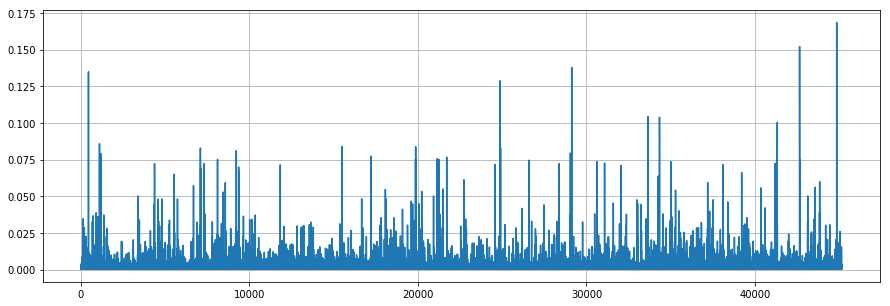

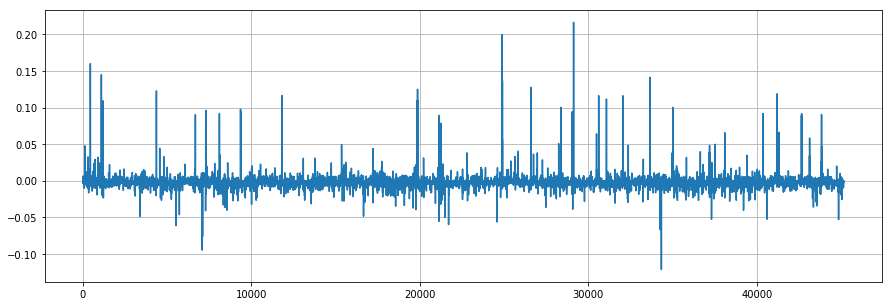

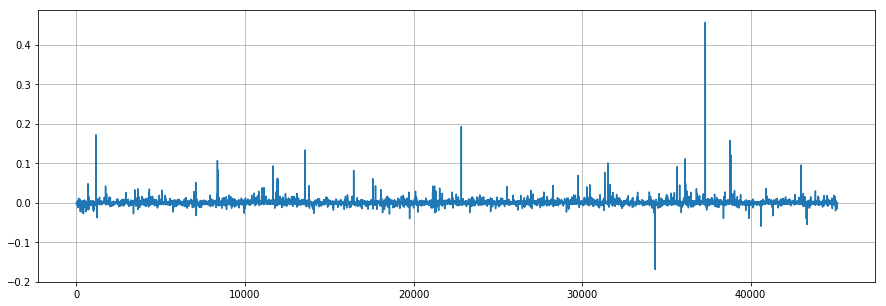

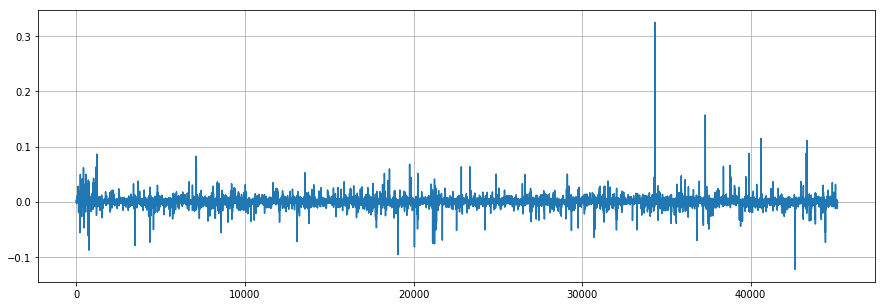

In [117]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)

In [118]:
#LDA LSA + DIRICHIET
dictionary = corpora.Dictionary(corpus)

In [119]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [120]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [121]:
lda_gensim.print_topics()

[(0,
  '0.005*"—ç—Ç–æ" + 0.002*"—Ñ–æ—Ç–æ" + 0.002*"—Ä—É–±–ª–µ–π" + 0.002*"–∫–æ—Ç–æ—Ä—ã–µ" + 0.002*"–≥–æ–¥–∞" + 0.002*"–≤—Ä–µ–º—è" + 0.002*"–≥–æ–¥—É" + 0.002*"–æ–±–ª–∞—Å—Ç–∏" + 0.002*"—Ç–∞–∫–∂–µ" + 0.002*"—Ä–æ—Å—Å–∏–∏"'),
 (1,
  '0.006*"—ç—Ç–æ" + 0.003*"—Ä—É–±–ª–µ–π" + 0.002*"–æ–±–ª–∞—Å—Ç–∏" + 0.002*"–≥–æ–¥–∞" + 0.002*"—Ä–æ—Å—Å–∏–∏" + 0.002*"–≤—Ä–µ–º—è" + 0.002*"—Ñ–æ—Ç–æ" + 0.002*"–≥–æ–¥—É" + 0.002*"—Ç–∞–∫–∂–µ" + 0.002*"–∫–æ—Ç–æ—Ä—ã–µ"'),
 (2,
  '0.005*"—ç—Ç–æ" + 0.003*"—Ä—É–±–ª–µ–π" + 0.003*"–≥–æ–¥–∞" + 0.002*"–æ—á–µ–Ω—å" + 0.002*"–≥–æ–¥—É" + 0.002*"—Ç–∞–∫–∂–µ" + 0.002*"–Ω–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–æ–π" + 0.002*"—Ñ–æ—Ç–æ" + 0.002*"–≤—Ä–µ–º—è" + 0.002*"–∫–æ—Ç–æ—Ä—ã–µ"'),
 (3,
  '0.005*"—ç—Ç–æ" + 0.002*"—Ä—É–±–ª–µ–π" + 0.002*"–∫–æ—Ç–æ—Ä—ã–µ" + 0.002*"–æ—á–µ–Ω—å" + 0.002*"—Ñ–æ—Ç–æ" + 0.002*"–≤—Ä–µ–º—è" + 0.002*"–Ω–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–æ–π" + 0.002*"–≥–æ–¥—É" + 0.002*"—Ä–æ—Å—Å–∏–∏" + 0.002*"–¥–æ–º–∞"')]

In [98]:
N_TOPICS = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [99]:
#SKLEARN
for item in N_TOPICS:
    print("n topics = " + str(item))
    lda_sklearn = LatentDirichletAllocation(n_components=item, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

n topics = 2
iteration: 1 of max_iter: 10, perplexity: 119179.7106
iteration: 2 of max_iter: 10, perplexity: 112904.3845
iteration: 3 of max_iter: 10, perplexity: 106265.9005
iteration: 4 of max_iter: 10, perplexity: 102579.4041
iteration: 5 of max_iter: 10, perplexity: 101912.2228
iteration: 6 of max_iter: 10, perplexity: 101899.4725
iteration: 7 of max_iter: 10, perplexity: 101899.4439
n topics = 3
iteration: 1 of max_iter: 10, perplexity: 219068.7186
iteration: 2 of max_iter: 10, perplexity: 213016.7392
iteration: 3 of max_iter: 10, perplexity: 212304.5193
iteration: 4 of max_iter: 10, perplexity: 211546.6310
iteration: 5 of max_iter: 10, perplexity: 210870.4183
iteration: 6 of max_iter: 10, perplexity: 210777.1890
iteration: 7 of max_iter: 10, perplexity: 210667.8655
iteration: 8 of max_iter: 10, perplexity: 210361.3565
iteration: 9 of max_iter: 10, perplexity: 210000.5235
iteration: 10 of max_iter: 10, perplexity: 209168.4084
n topics = 4
iteration: 1 of max_iter: 10, perplexity: 

In [96]:
#SKLEARN
for item in N_TOPICS:
    print("n topics = " + str(item))
    lda_sklearn = LatentDirichletAllocation(n_components=item, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

n topics = 1
iteration: 1 of max_iter: 10, perplexity: 62447.3676
iteration: 2 of max_iter: 10, perplexity: 62447.3676
n topics = 5
iteration: 1 of max_iter: 10, perplexity: 709000.2518
iteration: 2 of max_iter: 10, perplexity: 694216.2036
iteration: 3 of max_iter: 10, perplexity: 690118.5796
iteration: 4 of max_iter: 10, perplexity: 687191.5528
iteration: 5 of max_iter: 10, perplexity: 684404.5857
iteration: 6 of max_iter: 10, perplexity: 678401.0930
iteration: 7 of max_iter: 10, perplexity: 667935.5096
iteration: 8 of max_iter: 10, perplexity: 650629.4249
iteration: 9 of max_iter: 10, perplexity: 613950.5924
iteration: 10 of max_iter: 10, perplexity: 536974.0417
n topics = 10
iteration: 1 of max_iter: 10, perplexity: 11372069.4684
iteration: 2 of max_iter: 10, perplexity: 10708198.3131
iteration: 3 of max_iter: 10, perplexity: 9798079.6294
iteration: 4 of max_iter: 10, perplexity: 8298240.3693
iteration: 5 of max_iter: 10, perplexity: 6644830.9266
iteration: 6 of max_iter: 10, perple

In [129]:
#SKLEARN
lda_sklearn = LatentDirichletAllocation(n_components=4, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 396473.0712
iteration: 2 of max_iter: 10, perplexity: 386641.1609
iteration: 3 of max_iter: 10, perplexity: 382378.8628
iteration: 4 of max_iter: 10, perplexity: 377301.8805
iteration: 5 of max_iter: 10, perplexity: 372686.3399
iteration: 6 of max_iter: 10, perplexity: 367011.0322
iteration: 7 of max_iter: 10, perplexity: 355356.0675
iteration: 8 of max_iter: 10, perplexity: 334156.7286
iteration: 9 of max_iter: 10, perplexity: 299946.3189
iteration: 10 of max_iter: 10, perplexity: 266831.5672


In [130]:
lda_sklearn.components_.shape

(4, 45148)

In [132]:
stub = [0] * 4

for i in range(4):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
#     break

['bmw' '—Å—Ç–æ–∏–º–æ—Å—Ç—å' '–∫–∞—Ç–æ–∫' '—è–Ω–≤–∞—Ä—è' '–≥–æ–¥—É' '—É–ª–∏—Ü–∞' '—ç—Ç–æ' '–ø–æ–¥—Ä–æ–±–Ω–æ—Å—Ç–∏'
 '—á–∞—Å–æ–≤' '—Ä—É–±–ª–µ–π']
[ 0.08408575  0.08587365  0.10047718  0.10393378  0.1044146   0.12880417
  0.13494586  0.13792002  0.15222147  0.16869862]

['–ø–∞—Ä–∫–æ–≤–∫–∏' '–≥–æ–¥—É' '–æ–±–ª–∞—Å—Ç–∏' '–ø—Ä–∞–≤–∏–ª' '–∫–æ—Ç–æ—Ä—ã–µ' '—Ä—É–±–ª–µ–π' 'news' '–≥–æ–¥–∞'
 '—Ñ–æ—Ç–æ' '—ç—Ç–æ']
[ 0.11863163  0.12265564  0.12489764  0.12740194  0.13652965  0.14119258
  0.14467247  0.15970945  0.19936046  0.2162052 ]

['–ø–æ–±–µ–¥—ã' 'halloween' '–∞—Ç—Ä–∏–±—É—Ç–æ–≤' '–º–∞–≥–∞–∑–∏–Ω–µ' '–æ–±–ª–∞—Å—Ç—å' '–∫–∞–±—ã' '–±–∞–±—ã'
 'nokia' '–µ–ª–∫–∞' '–º–∏—Å—Å']
[ 0.11101801  0.12065967  0.13341392  0.14570616  0.15782388  0.17195522
  0.17538999  0.19253525  0.37929338  0.45651917]

['spacetour' '—É–¥–∞—Ä–∏–ª–∞—Å—å' '–ª–µ–¥—è–Ω–∫–µ' '–ø–æ–¥–∞—Ä–æ–∫' '–ø—Ä–∏–∑—ã–≤–Ω–∏–∫' '–ø—Ä–∏–∑—ã–≤–Ω–∏–∫–æ–≤'
 '—Ü–∏—Ä–∫–µ' '–∞–ª–µ–∫—Å–µ–µ–≤—Å–∫–∞—è' '–∂—é—Ä–∏' '–∑—Ä–∏—Ç–µ–ª–∏']
[ 0.06798688  0.08239212  